# Convolution neural network beyond the human eyes 

<div class="alert alert-block alert-info">



Case Study: “Transgender Face Recognition”<a class="anchor"><a id='toc'></a></b><br>
* [<font color='#E8800A'>0. Identify Business needs</font>](#first-bullet)<br>
- [<font color='#E8800A'>1. Import the needed libraries</font>](#second-bullet)<br>
- [<font color='#E8800A'>2. Load Data</font>](#third-bullet)<br>
- [<font color='#E8800A'>3. Base CNN Model</font>](#fourth-bullet)<br>
- [<font color='#E8800A'>4. Visualizing convnets learning</font>](#fifth-bullet)<br>
- [<font color='#E8800A'>5. Applying Dropout</font>](#sixth-bullet)<br>
- [<font color='#E8800A'>6. Data Augmentation and Dropout</font>](#seventh-bullet)<br>
- [<font color='#E8800A'>7. Optimizing The model with TensorBoard</font>](#eigth-bullet)<br>
- [<font color='#E8800A'>8. Transfer learning</font>](#nineth-bullet)<br>
- [<font color='#E8800A'>9. Extensions</font>](#tenth-bullet)<br>



</div>



# <font color='#E8800A'>0. Identify Business needs</font> <a class="anchor" id="first-bullet"></a>
[Back to TOC](#toc)

### Get overview about the problem and data availible

#### Gender Classification Dataset
###### Male Female image dataset
The data set is of cropped images of male and female . It is split into training and validation directory. 
Training contains ~23,000 images of each class and validation directory contains ~5,500 images of each class.

Collection methodology

The data was collected from the different sources in the internet including scraping the web. The data mostly consist of the image from imdb dataset. The IMDB dataset has almost 200k data which was carefully cleaned and seperated in the two different classes. After separating the data, the faces from the data were cropped and saved to different directory

Created on 2019-12-15 by Ashutosh Chauhan (Version 1) <br>
https://www.kaggle.com/cashutosh/gender-classification-dataset

# <font color='#E8800A'>1. Import the needed libraries</font> <a class="anchor" id="second-bullet"></a>
[Back to TOC](#toc)

In [58]:
# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools

from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import scikitplot as skplt
import time
from keras.models import Model
from keras.models import load_model

# import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dropout

# <font color='#E8800A'>2. Load Data</font> <a class="anchor" id="third-bullet"></a>
[Back to TOC](#toc)

### Count how many pictures are in each training split (train/validation)

In [2]:
print('total training male images:', len(os.listdir('dataset/Training/male')))
print('total training female images:', len(os.listdir('dataset/Training/female')))
print('total validation male images:', len(os.listdir('dataset/Validation/female')))
print('total validation female images:', len(os.listdir('dataset/Validation/female')))

print('total test male images:', len(os.listdir('dataset/Test/male')))
print('total test female images:', len(os.listdir('dataset/Test/female')))

print('total test transgender male images:', len(os.listdir('dataset/Test_trans/male')))
print('total test transgender female images:', len(os.listdir('dataset/Test_trans/female')))

total training male images: 21766
total training female images: 21243
total validation male images: 5841
total validation female images: 5841
total test male images: 2000
total test female images: 2000
total test transgender male images: 660
total test transgender female images: 660


# <font color='#E8800A'>3. Base CNN Model</font> <a class="anchor" id="fourth-bullet"></a>
[Back to TOC](#toc)

## 3.1 Building the network

In [3]:
# Initialising the CNN
classifier1 = Sequential()

# Step 1 - Convolution
classifier1.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier1.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier1.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier1.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier1.add(Flatten())

# Step 4 - Full connection
classifier1.add(Dense(units = 128, activation = 'relu'))
classifier1.add(Dense(units = 2, activation = 'softmax'))

classifier1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [4]:
# Compiling the CNN
classifier1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#classifier.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=0.0004), metrics = ['acc'])

## 3.2 Data preprocessing

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
training_set = train_datagen.flow_from_directory('dataset/Training',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory('dataset/Validation',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'])
                                            #class_mode = 'binary'
                                            # , shuffle=False
    
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'], shuffle=False)
                                            #class_mode = 'binary'
    
Test_trans_set = test_datagen.flow_from_directory('dataset/Test_trans',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'], shuffle=False)
                                            #class_mode = 'binary'

Found 43009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.


## 3.3 Model fit

In [7]:
history=classifier1.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 20,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/20
1344/1344 [==============================] - 133s 98ms/step - loss: 0.3391 - accuracy: 0.8442 - val_loss: 0.1991 - val_accuracy: 0.9231
Epoch 2/20
1344/1344 [==============================] - 88s 65ms/step - loss: 0.1630 - accuracy: 0.9389 - val_loss: 0.1460 - val_accuracy: 0.9475
Epoch 3/20
1344/1344 [==============================] - 87s 65ms/step - loss: 0.1269 - accuracy: 0.9535 - val_loss: 0.1245 - val_accuracy: 0.9513
Epoch 4/20
1344/1344 [==============================] - 87s 65ms/step - loss: 0.1131 - accuracy: 0.9601 - val_loss: 0.1099 - val_accuracy: 0.9613
Epoch 5/20
1344/1344 [==============================] - 86s 64ms/step - loss: 0.0924 - accuracy: 0.9675 - val_loss: 0.1070 - val_accuracy: 0.9619
Epoch 6/20
1344/1344 [==============================] - 86s 64ms/step - loss: 0.0765 - accuracy: 0.9729 - val_loss: 0.1203 - val_accuracy: 0.9531
Epoch 7/20
1344/1344 [==============================] - 86s 64ms/step - loss: 0.0622 - accuracy: 0.9783 - val_loss: 0.1313 

In [8]:
# # save the model
# classifier1.save('Gender_Classifier_ver1_20.h5')

In [216]:
# # Loading the model
# classifier1 = load_model('Gender_Classifier_ver1_20.h5')
# classifier1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

## 3.4 Displaying curves of loss and accuracy during training

In [8]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [9]:
#history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

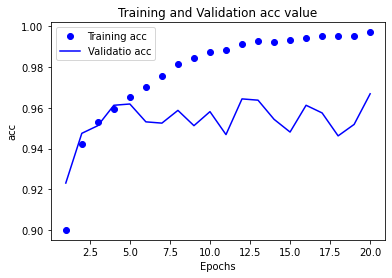

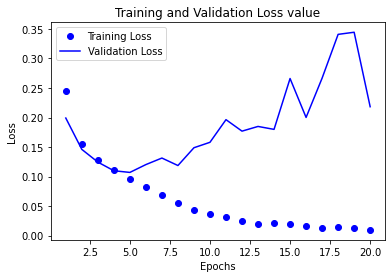

In [10]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validatio acc')
plt.title('Training and Validation acc value')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### The graphics bellow show the accuracy and loss value on training and validation for twenty epochs. 
### The Accuracy tend to increase on training set but remained stable on the validation. On the training the value started at 0.8917 and ended at 0.9937. On other hand the validation started at 0.9375 and ended at 0.9500.
 
### The  loss value tend to decrease on training but increase on the validation. On the training the value started at 0.2599 and ended at 0.0114. On other hand the validation started at 0.1685 and ended at 0.2935.

### In general the model had good results although, the behavior of the graphics indicates that the model is overfitting on the training set.



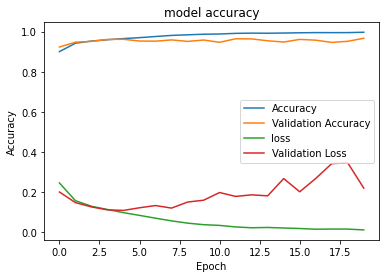

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [12]:
# history=classifier1.fit(training_set,
#                          steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
#                          epochs = 5,
#                          validation_data = val_set,
#                          validation_steps = 50)

## 3.5 Evaluation gender file

In [13]:
# Predicting the Test set results
#y_pred = classifier.predict_classes(val_set, 50)
y_pred = np.argmax(classifier1.predict(test_set), axis=-1)
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [14]:
y_true = test_set.classes
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [15]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1870,  130],
       [  75, 1925]], dtype=int64)

In [16]:
target_names = ['female', 'male']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

      female       0.96      0.94      0.95      2000
        male       0.94      0.96      0.95      2000

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [24]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title="Confusion matrix",
                         cmap=plt.cm.Blues):
    """"
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`
    """
    plt.imshow (cm, interpolation ="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks= np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("confusion matrix, without normalization")
    
    print(cm)
    thresh =cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j]> thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label") 

confusion matrix, without normalization
[[1870  130]
 [  75 1925]]


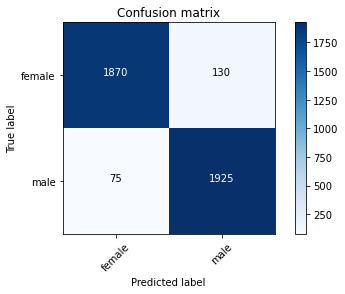

In [18]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix")

# After training stage, the model was used on the test dataset resulting in good scores for both precision and recall (0.96 for both) which indicates that male and female are being well classified.

## 3.6 Evaluation Transgender file

In [19]:
y_pred_trans = np.argmax(classifier1.predict(Test_trans_set), axis=-1)
y_pred_trans

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [20]:
y_true_trans = Test_trans_set.classes
y_true_trans

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
cm_trans = confusion_matrix(y_true_trans, y_pred_trans)
cm_trans

array([[139, 521],
       [437, 223]], dtype=int64)

In [22]:
target_names = ['female', 'male']
cr_trans = classification_report(y_true_trans, y_pred_trans, target_names=target_names)
print(cr_trans)

              precision    recall  f1-score   support

      female       0.24      0.21      0.22       660
        male       0.30      0.34      0.32       660

    accuracy                           0.27      1320
   macro avg       0.27      0.27      0.27      1320
weighted avg       0.27      0.27      0.27      1320



confusion matrix, without normalization
[[139 521]
 [437 223]]


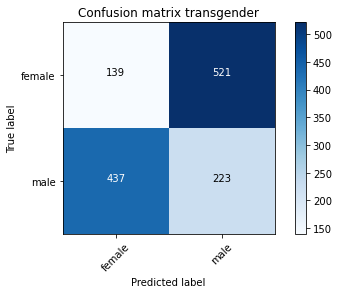

In [23]:
plot_confusion_matrix(cm=cm_trans, classes=target_names, title="Confusion matrix transgender") 

#  In addition the model was applied on the transgenders test dataset and the result were not good for both precision (XX) and recall (XX) which indicates that the model is not able to identify the born gender.

# <font color='#E8800A'>4. Visualizing convnets learning</font> <a class="anchor" id="fifth-bullet"></a>
[Back to TOC](#toc)

In [4]:
# Preprocessing a single image
img_path = 'dataset/Training/male/099671.jpg.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /=255

print(img_tensor.shape)

(1, 64, 64, 3)


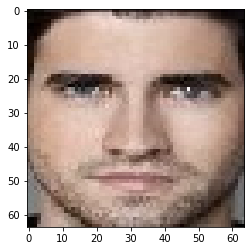

(1, 64, 64, 3)


In [6]:
img_path = 'dataset/Training/male/099671.jpg.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [9]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = classifier1.predict_classes(images, batch_size=10)
print("Predicted class is:",classes)

Predicted class is: [1]


C:\Users\putos\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [11]:
# Instantiating a model from an input tensor and a list of output tensors
from tensorflow.keras import models
layer_outputs = [layer.output for layer in classifier1.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=classifier1.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [14]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

In [16]:
len(activations)

7

In [30]:
first_layer_activation = activations[2]
print(first_layer_activation.shape)

(1, 29, 29, 32)


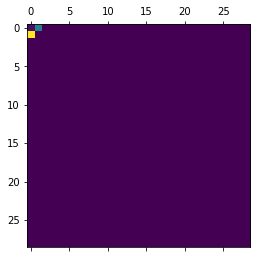

In [31]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')

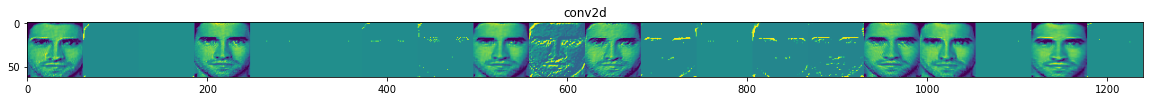

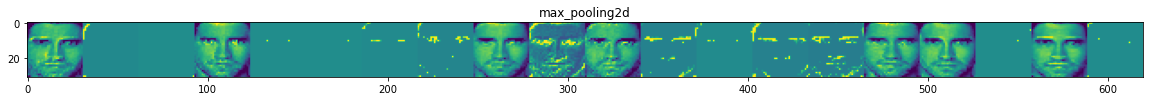

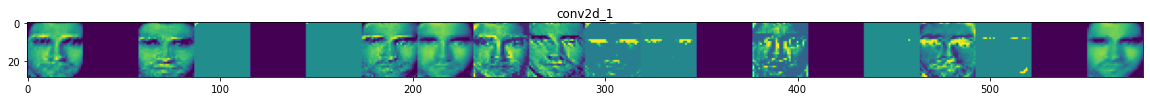

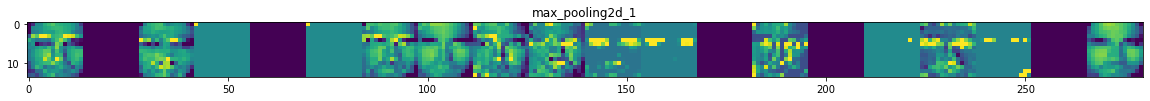

In [33]:
layer_names = []
for layer in classifier1.layers[:4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 20

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

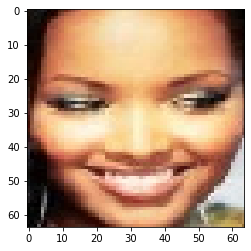

(1, 64, 64, 3)


In [38]:
img_path = 'dataset/Training/female/137832.jpg.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [39]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = classifier1.predict_classes(images, batch_size=10)
# print("Predicted class is:",classes)

Predicted class is: [1]


In [40]:
# Instantiating a model from an input tensor and a list of output tensors
from tensorflow.keras import models
layer_outputs = [layer.output for layer in classifier1.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=classifier1.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [41]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

In [42]:
first_layer_activation = activations[2]
print(first_layer_activation.shape)

(1, 29, 29, 32)


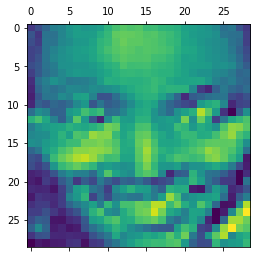

In [49]:
plt.matshow(first_layer_activation[0, :, :, 6], cmap='viridis')

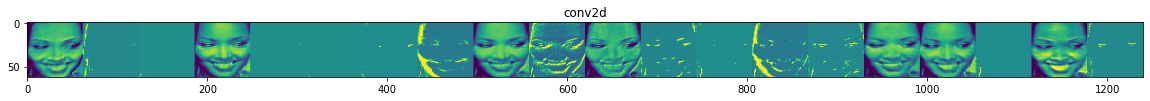

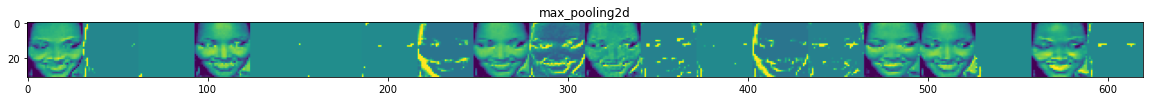

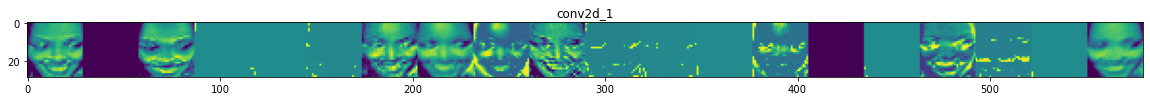

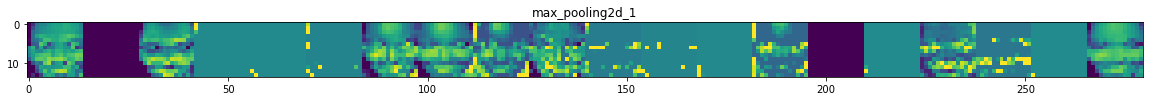

In [47]:
layer_names = []
for layer in classifier1.layers[:4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 20

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

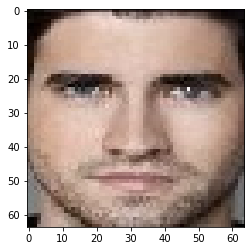

In [8]:
# Displaying the test pictures
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [12]:
# Instantiating a model from an input tensor and a list of output tensors
from tensorflow.keras import models

layer_outputs = [layer.output for layer in classifier1.layers[:8]]
activation_model = models.Model(inputs=classifier1.input, outputs=layer_outputs)

In [13]:
# Runing the model in predict mode
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 62, 62, 32)


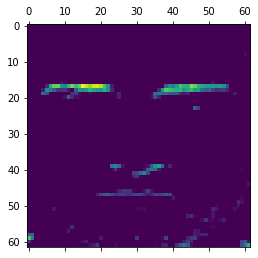

In [25]:
# Visualizing the fourth channel
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')

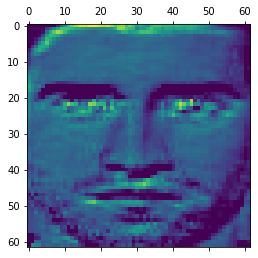

In [27]:
# Visualizing the fourth channel
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

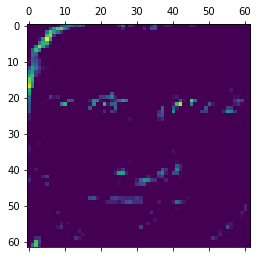

In [28]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

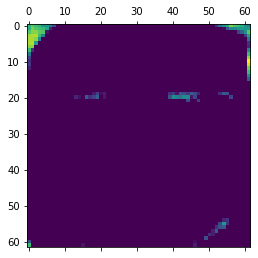

In [29]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')

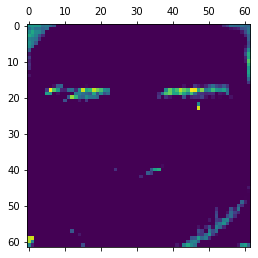

In [33]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

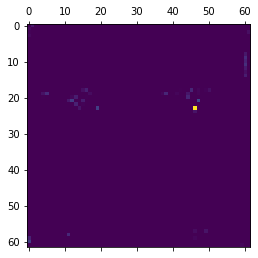

In [34]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 6], cmap='viridis')

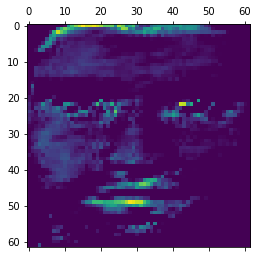

In [35]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

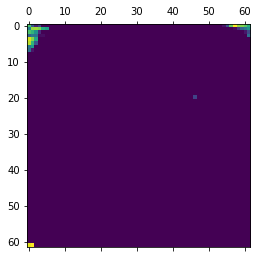

In [36]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 8], cmap='viridis')

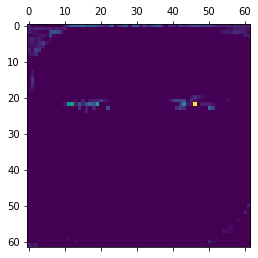

In [37]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 9], cmap='viridis')

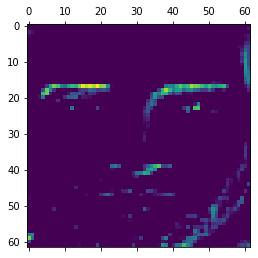

In [38]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis')

In [40]:
# Preprocessing a single image
img_path = 'dataset/Training/female/137803.jpg.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /=255

print(img_tensor.shape)

(1, 64, 64, 3)


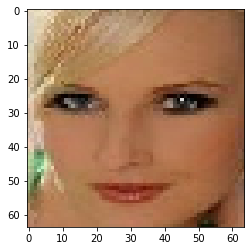

In [41]:
# Displaying the test pictures
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [133]:
# Instantiating a model from an input tensor and a list of output tensors
from tensorflow.keras import models

layer_outputs = [layer.output for layer in classifier1.layers[:10]]
activation_model = models.Model(inputs=classifier1.input, outputs=layer_outputs)

In [397]:
# Runing the model in predict mode
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[3]
print(first_layer_activation.shape)

(1, 14, 14, 32)


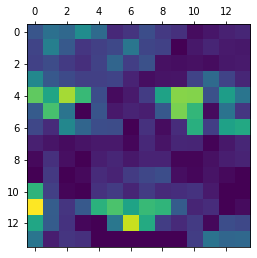

In [398]:
# Visualizing the fourth channel
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')

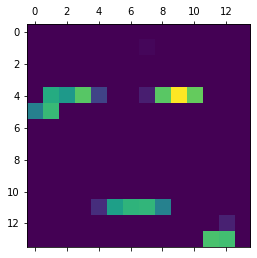

In [399]:
# Visualizing the fourth channel
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

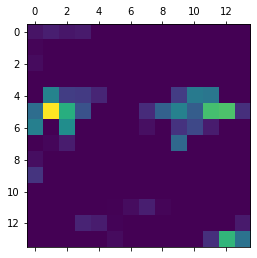

In [400]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

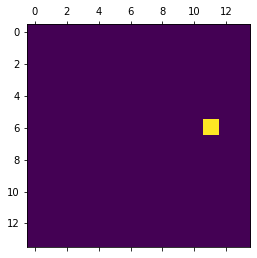

In [401]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')

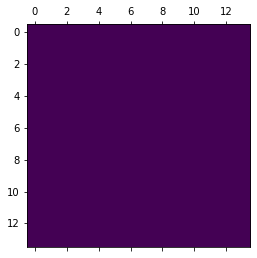

In [402]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

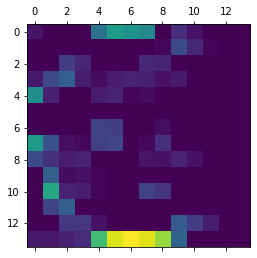

In [403]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

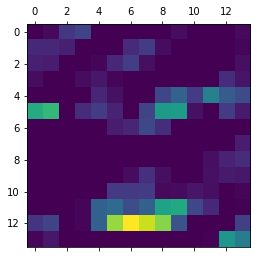

In [404]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 6], cmap='viridis')

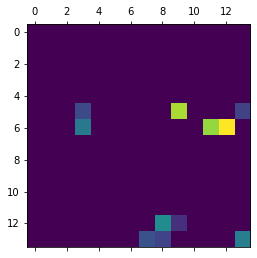

In [405]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

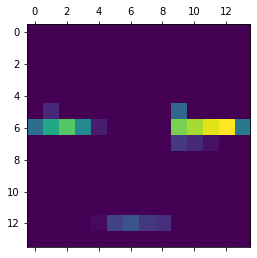

In [406]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 8], cmap='viridis')

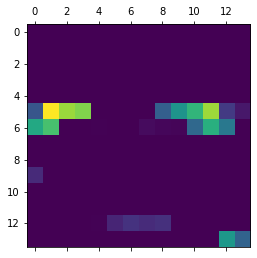

In [407]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 9], cmap='viridis')

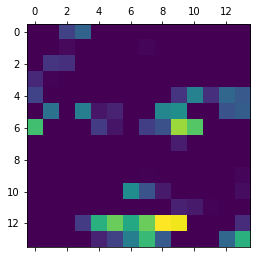

In [408]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis')

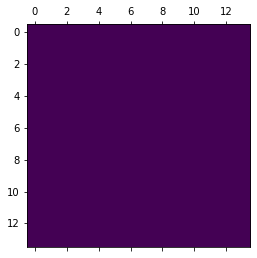

In [409]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 14], cmap='viridis')

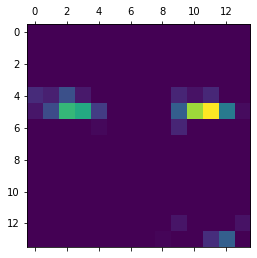

In [410]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

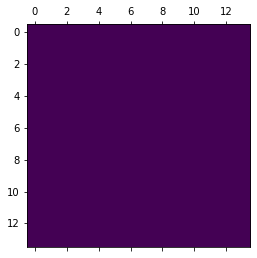

In [411]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 16], cmap='viridis')

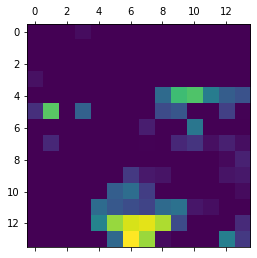

In [412]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 17], cmap='viridis')

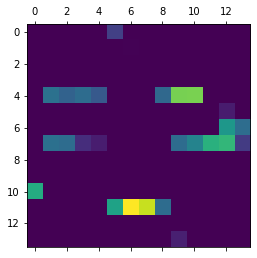

In [413]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 18], cmap='viridis')

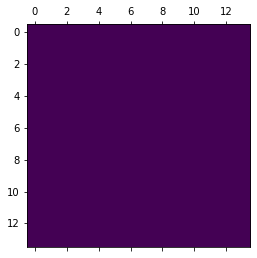

In [414]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')

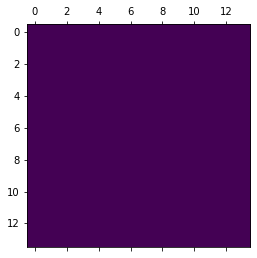

In [415]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')

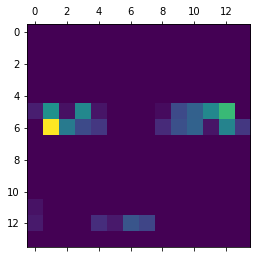

In [416]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')

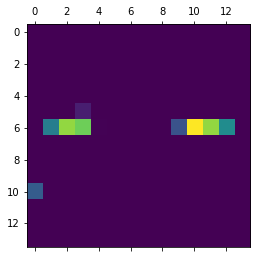

In [417]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 21], cmap='viridis')

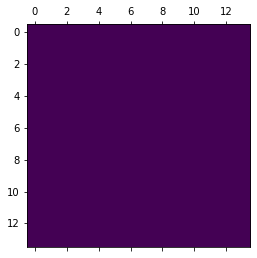

In [418]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 22], cmap='viridis')

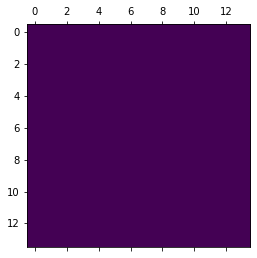

In [419]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 23], cmap='viridis')

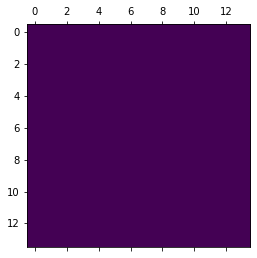

In [420]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 24], cmap='viridis')

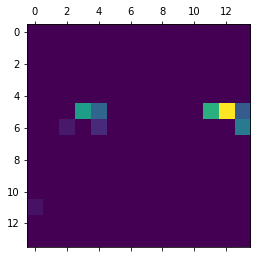

In [421]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 25], cmap='viridis')

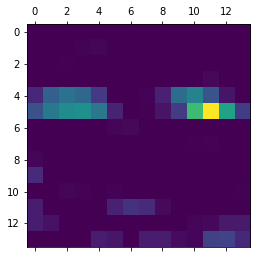

In [422]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 26], cmap='viridis')

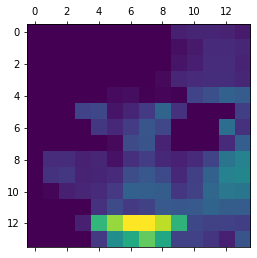

In [423]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 27], cmap='viridis')

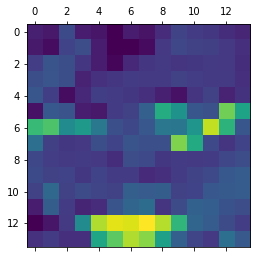

In [424]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 28], cmap='viridis')

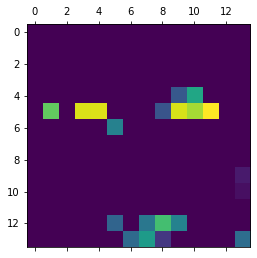

In [425]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 29], cmap='viridis')

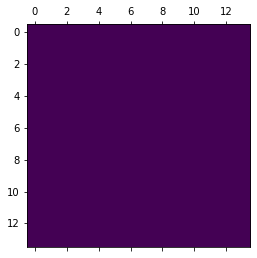

In [426]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')

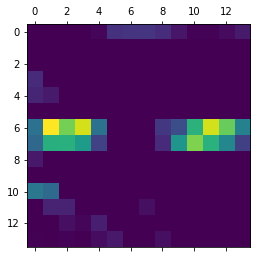

In [427]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 31], cmap='viridis')

(1, 64, 64, 3)


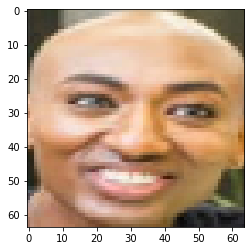

In [141]:
# Preprocessing a single image
img_path = 'dataset/Test_trans/female/71female.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /=255

print(img_tensor.shape)

# Displaying the test pictures
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

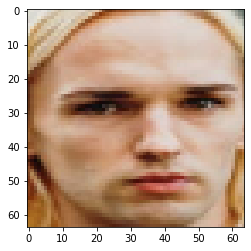

(1, 64, 64, 3)


In [142]:
img_path = 'dataset/Test_trans/male/0male.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

# <font color='#E8800A'>5. Appying Dropout</font> <a class="anchor" id="sixth-bullet"></a>
[Back to TOC](#toc)

## 5.1 Building the network

In [24]:
# Initialising the CNN
classifier2 = Sequential()

# Step 1 - Convolution
classifier2.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier2.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier2.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier2.add(Flatten())

# Adding dropout
classifier2.add(layers.Dropout(0.5))

# Step 4 - Full connection
classifier2.add(Dense(units = 128, activation = 'relu'))
classifier2.add(Dense(units = 2, activation = 'softmax'))

classifier2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [25]:
# Compiling the CNN
classifier2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [26]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [27]:
training_set = train_datagen.flow_from_directory('dataset/Training',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory('dataset/Validation',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'])
                                            #class_mode = 'binary'
                                            # , shuffle=False
    
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'], shuffle=False)
                                            #class_mode = 'binary'
    
Test_trans_set = test_datagen.flow_from_directory('dataset/Test_trans',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'], shuffle=False)
                                            #class_mode = 'binary'

Found 43009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.


In [28]:
history=classifier2.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 20,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/20
1344/1344 [==============================] - 195s 144ms/step - loss: 0.3728 - accuracy: 0.8308 - val_loss: 0.1605 - val_accuracy: 0.9362
Epoch 2/20
1344/1344 [==============================] - 89s 66ms/step - loss: 0.1885 - accuracy: 0.9270 - val_loss: 0.1254 - val_accuracy: 0.9494
Epoch 3/20
1344/1344 [==============================] - 88s 65ms/step - loss: 0.1583 - accuracy: 0.9391 - val_loss: 0.1226 - val_accuracy: 0.9644
Epoch 4/20
1344/1344 [==============================] - 87s 65ms/step - loss: 0.1339 - accuracy: 0.9507 - val_loss: 0.1135 - val_accuracy: 0.9625
Epoch 5/20
1344/1344 [==============================] - 86s 64ms/step - loss: 0.1233 - accuracy: 0.9547 - val_loss: 0.1226 - val_accuracy: 0.9575
Epoch 6/20
1344/1344 [==============================] - 87s 64ms/step - loss: 0.1195 - accuracy: 0.9566 - val_loss: 0.0906 - val_accuracy: 0.9681
Epoch 7/20
1344/1344 [==============================] - 87s 65ms/step - loss: 0.1082 - accuracy: 0.9597 - val_loss: 0.0973

In [29]:
#history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

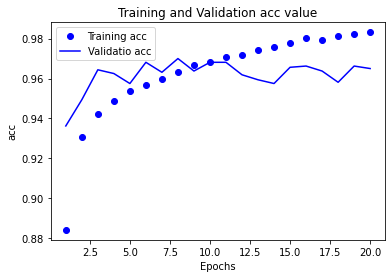

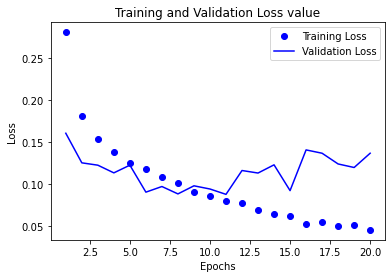

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validatio acc')
plt.title('Training and Validation acc value')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### In order to reduce the overfitting and to increase the score dropout was applied with the value of 0.5.

### According with the graphics the accuracy on train and validation are close. This indicates that overfitting had been reduced.


## 5.2 Test set Prediction

### 5.2.1 Gender Prediction (Dropout)

In [31]:
y_pred = np.argmax(classifier2.predict(test_set), axis=-1)
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [32]:
y_true = test_set.classes
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [33]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1913,   87],
       [  83, 1917]], dtype=int64)

In [34]:
target_names = ['female', 'male']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

      female       0.96      0.96      0.96      2000
        male       0.96      0.96      0.96      2000

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



confusion matrix, without normalization
[[1913   87]
 [  83 1917]]


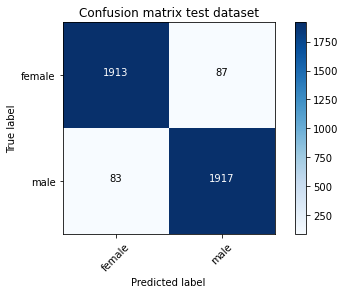

In [35]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix test dataset")

# The model with dropout had slighter better results than the base model on precision and recall. The male misclassified decreased from 96 to 71. therefore the female sightly increased from 83 to 88.


 

## 5.3 Trandender set Prediction

### 5.3.1 Transgender Prediction (Dropout)

In [36]:
y_pred_trans = np.argmax(classifier2.predict(Test_trans_set), axis=-1)

In [37]:
y_true_trans = Test_trans_set.classes
y_true_trans

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
cm_trans = confusion_matrix(y_true_trans, y_pred_trans)
cm_trans

array([[126, 534],
       [454, 206]], dtype=int64)

In [39]:
target_names = ['female', 'male']
cr_trans = classification_report(y_true_trans, y_pred_trans, target_names=target_names)
print(cr_trans)

              precision    recall  f1-score   support

      female       0.22      0.19      0.20       660
        male       0.28      0.31      0.29       660

    accuracy                           0.25      1320
   macro avg       0.25      0.25      0.25      1320
weighted avg       0.25      0.25      0.25      1320



confusion matrix, without normalization
[[126 534]
 [454 206]]


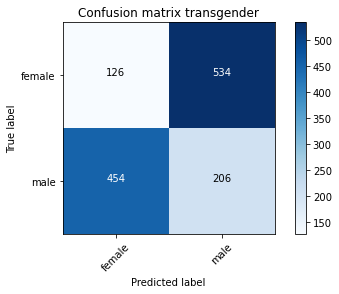

In [40]:
plot_confusion_matrix(cm=cm_trans, classes=target_names, title="Confusion matrix transgender")

# On the transgender dataset was verified the same improvement. The misclassified born gender male decreased from XXX to XX and for born gender from XX to XX.      

# <font color='#E8800A'>6. Data Augmentation and Dropout</font> <a class="anchor" id="seventh-bullet"></a>
[Back to TOC](#toc)

In [41]:
# Initialising the CNN
classifier3 = Sequential()

# Step 1 - Convolution
classifier3.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier3.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier3.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier3.add(Flatten())

# Adding dropout
classifier3.add(layers.Dropout(0.5))

# Step 4 - Full connection
classifier3.add(Dense(units = 128, activation = 'relu'))
classifier3.add(Dense(units = 2, activation = 'softmax'))

classifier3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [42]:
# Compiling the CNN
classifier3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [43]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)

                                    

test_datagen = ImageDataGenerator(rescale = 1./255)

In [44]:
training_set = train_datagen.flow_from_directory('dataset/Training',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory('dataset/Validation',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'], shuffle=False)
                                            #class_mode = 'binary'
    
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'], shuffle=False)
                                            #class_mode = 'binary'
    
Test_trans_set = test_datagen.flow_from_directory('dataset/Test_trans',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'], shuffle=False)
                                            #class_mode = 'binary'

Found 43009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.


In [45]:
history=classifier3.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 20,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/20
1344/1344 [==============================] - 10902s 8s/step - loss: 0.6271 - accuracy: 0.6447 - val_loss: 0.3061 - val_accuracy: 0.8894
Epoch 2/20
1344/1344 [==============================] - 263s 195ms/step - loss: 0.4943 - accuracy: 0.7633 - val_loss: 0.2207 - val_accuracy: 0.9106
Epoch 3/20
1344/1344 [==============================] - 335s 249ms/step - loss: 0.3955 - accuracy: 0.8266 - val_loss: 0.1991 - val_accuracy: 0.9200
Epoch 4/20
1344/1344 [==============================] - 174s 130ms/step - loss: 0.3533 - accuracy: 0.8497 - val_loss: 0.1651 - val_accuracy: 0.9337
Epoch 5/20
1344/1344 [==============================] - 163s 122ms/step - loss: 0.3300 - accuracy: 0.8611 - val_loss: 0.1941 - val_accuracy: 0.9269
Epoch 6/20
1344/1344 [==============================] - 153s 114ms/step - loss: 0.3158 - accuracy: 0.8677 - val_loss: 0.2465 - val_accuracy: 0.8931
Epoch 7/20
1344/1344 [==============================] - 133s 99ms/step - loss: 0.3046 - accuracy: 0.8731 - val_lo

In [46]:
#history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

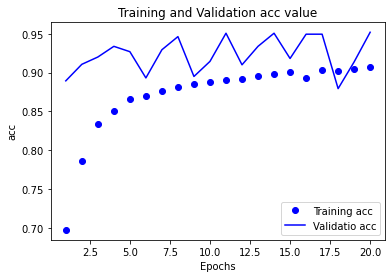

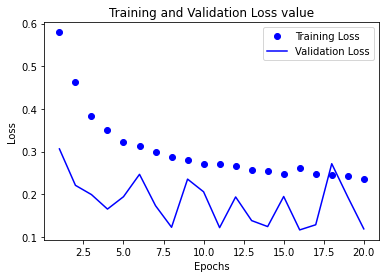

In [47]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validatio acc')
plt.title('Training and Validation acc value')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 6.1 Test set Prediction

### After the dropout, data augmentation was added but the results did not improved. The overfitting increased and the scores decreased. The precision and recall decresead to 0.93 and 0.94 on the test dataset and xx, yy on transgender dataset. Because of that data augnmentation was not consedered. 


In [48]:
y_pred = np.argmax(classifier3.predict(test_set), axis=-1)
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [49]:
y_true = test_set.classes
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [50]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1880,  120],
       [ 113, 1887]], dtype=int64)

In [51]:
target_names = ['female', 'male']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

      female       0.94      0.94      0.94      2000
        male       0.94      0.94      0.94      2000

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



confusion matrix, without normalization
[[1880  120]
 [ 113 1887]]


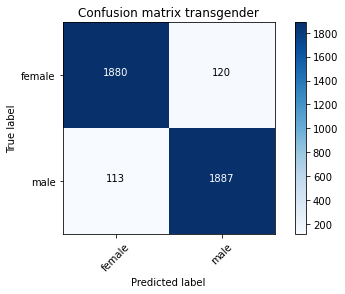

In [52]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix transgender")

### 6.2 Trangender Prediction

In [53]:
y_pred_trans = np.argmax(classifier3.predict(Test_trans_set), axis=-1)
y_pred_trans

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [54]:
y_true_trans = Test_trans_set.classes
y_true_trans

array([0, 0, 0, ..., 1, 1, 1])

In [55]:
target_names = ['female', 'male']
cr_trans = classification_report(y_true_trans, y_pred_trans, target_names=target_names)
print(cr_trans)

              precision    recall  f1-score   support

      female       0.22      0.22      0.22       660
        male       0.21      0.21      0.21       660

    accuracy                           0.22      1320
   macro avg       0.22      0.22      0.22      1320
weighted avg       0.22      0.22      0.22      1320



confusion matrix, without normalization
[[126 534]
 [454 206]]


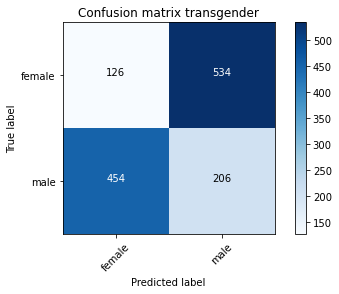

In [56]:
plot_confusion_matrix(cm=cm_trans, classes=target_names, title="Confusion matrix transgender")

# <font color='#E8800A'>7. Optimizing The model with TensorBoard</font><a class="anchor" id="eigth-bullet"></a>
[Back to TOC](#toc)

### In order to tune the model, differents combinations of dense layers, convolution layers, dropout values and optimizers were tested. Using tensorboard was possible to view which combination provides better results and the right epoch to stop training the model and avoid overfitting. 
### combinations:
        dense_layers = [0, 1, 2]
        layers_sizes= [32, 64, 128]
        conv_layers = [1,2,3]
        dropout_values =[0.3, 0.5]
        optimizer_values= ["adam", 'rmsprop']

After several combination the model with XX dense layers, with XX neurons, xx convolution got the best performance in train and for validation. And as can be seen by the graphic after XX epochs the loss and accracy score are increasing which meaning the model started to overfitting and to avoid this the model was trained again until XX  epochs.

In [233]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [234]:
training_set = train_datagen.flow_from_directory('dataset/Training',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory('dataset/Validation',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'])
                                            #class_mode = 'binary'
                                            # , shuffle=False
    
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'], shuffle=False)
                                            #class_mode = 'binary'
    
Test_trans_set = test_datagen.flow_from_directory('dataset/Test_trans',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            classes = ['female', 'male'], shuffle=False)
                                            #class_mode = 'binary'

Found 43009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.


In [19]:
dense_layers = [0, 1, 2]
layers_sizes= [32, 64, 128]
conv_layers = [1,2,3]
dropout_values =[0.3, 0.5]
optimizer_values= ["adam", 'rmsprop']

In [20]:
for dense_layer in dense_layers:
    for layers_size in layers_sizes:
        for conv_layer in conv_layers:
            for dropout_value in dropout_values:
                for optimizer_value in optimizer_values:
                    Name = "{}-conv-{}-nodes-{}-dense-{}-dropout-{}-optimizer-{}".format(conv_layer, layers_size, dense_layer, dropout_value, optimizer_value, int(time.time()))
                    print(Name)
                    # Initialising the CNN
                    classifier_tensorboard = Sequential()

                    # Step 1 - Convolution
                    classifier_tensorboard.add(Conv2D(layers_size, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

                    # Step 2 - Pooling
                    classifier_tensorboard.add(MaxPooling2D(pool_size = (2, 2)))

                    for l in range(conv_layer-1):
                        # Adding a second convolutional layer
                        classifier_tensorboard.add(Conv2D(layers_size, (3, 3), activation = 'relu'))
                        classifier_tensorboard.add(MaxPooling2D(pool_size = (2, 2)))

                    # Step 3 - Flattening
                    classifier_tensorboard.add(Flatten())
                    # Adding dropout
                    for l in dropout_values:
                        classifier_tensorboard.add(layers.Dropout(dropout_value))            

                    for l in range(dense_layer):
                        classifier_tensorboard.add(Dense(units = layers_size, activation = 'relu'))


                    classifier_tensorboard.add(Dense(units = 2, activation = 'softmax'))

                    # Compiling the CNN
                    for l in range(len(optimizer_values)):
                        classifier_tensorboard.compile(optimizer = optimizer_value, loss = 'categorical_crossentropy', metrics = ['accuracy'])
                    
                    classifier_tensorboard.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 20,
                         validation_data = val_set,
                         #validation_steps = 50,
                         callbacks=[EarlyStopping(monitor = "accuracy", patience=3),
                                    TensorBoard(log_dir="logs/{}".format(Name))])# 

                    

1-conv-32-nodes-0-dense-0.3-dropout-adam-optimizer-1617020277
Epoch 1/20
1344/1344 [==============================] - 100s 74ms/step - loss: 0.3605 - accuracy: 0.8437 - val_loss: 0.2081 - val_accuracy: 0.9255
Epoch 2/20
1344/1344 [==============================] - 84s 62ms/step - loss: 0.2226 - accuracy: 0.9145 - val_loss: 0.1814 - val_accuracy: 0.9331
Epoch 3/20
1344/1344 [==============================] - 95s 71ms/step - loss: 0.1994 - accuracy: 0.9242 - val_loss: 0.2045 - val_accuracy: 0.9236
Epoch 4/20
1344/1344 [==============================] - 91s 67ms/step - loss: 0.1892 - accuracy: 0.9302 - val_loss: 0.1664 - val_accuracy: 0.9402
Epoch 5/20
1344/1344 [==============================] - 90s 67ms/step - loss: 0.1830 - accuracy: 0.9311 - val_loss: 0.1613 - val_accuracy: 0.9433
Epoch 6/20
1344/1344 [==============================] - 82s 61ms/step - loss: 0.1789 - accuracy: 0.9327 - val_loss: 0.1771 - val_accuracy: 0.9371
Epoch 7/20
1344/1344 [==============================] - 73s 5

1344/1344 [==============================] - 76s 57ms/step - loss: 0.2013 - accuracy: 0.9235 - val_loss: 0.1477 - val_accuracy: 0.9512
Epoch 8/20
1344/1344 [==============================] - 79s 59ms/step - loss: 0.1953 - accuracy: 0.9246 - val_loss: 0.1389 - val_accuracy: 0.9501
Epoch 9/20
1344/1344 [==============================] - 96s 71ms/step - loss: 0.1911 - accuracy: 0.9277 - val_loss: 0.1240 - val_accuracy: 0.9545
Epoch 10/20
1344/1344 [==============================] - 80s 60ms/step - loss: 0.1924 - accuracy: 0.9284 - val_loss: 0.1200 - val_accuracy: 0.9569
Epoch 11/20
1344/1344 [==============================] - 74s 55ms/step - loss: 0.1877 - accuracy: 0.9284 - val_loss: 0.1266 - val_accuracy: 0.9554
Epoch 12/20
1344/1344 [==============================] - 74s 55ms/step - loss: 0.1849 - accuracy: 0.9283 - val_loss: 0.1211 - val_accuracy: 0.9542
Epoch 13/20
1344/1344 [==============================] - 73s 55ms/step - loss: 0.1870 - accuracy: 0.9268 - val_loss: 0.1278 - val_ac

1344/1344 [==============================] - 111s 83ms/step - loss: 0.1377 - accuracy: 0.9495 - val_loss: 0.1790 - val_accuracy: 0.9381
Epoch 17/20
1344/1344 [==============================] - 124s 92ms/step - loss: 0.1421 - accuracy: 0.9480 - val_loss: 0.1825 - val_accuracy: 0.9376
Epoch 18/20
1344/1344 [==============================] - 115s 86ms/step - loss: 0.1368 - accuracy: 0.9497 - val_loss: 0.1841 - val_accuracy: 0.9394
Epoch 19/20
1344/1344 [==============================] - 112s 83ms/step - loss: 0.1304 - accuracy: 0.9521 - val_loss: 0.1840 - val_accuracy: 0.9397
Epoch 20/20
1344/1344 [==============================] - 111s 83ms/step - loss: 0.1368 - accuracy: 0.9497 - val_loss: 0.2245 - val_accuracy: 0.9292
1-conv-64-nodes-0-dense-0.3-dropout-rmsprop-optimizer-1617038449
Epoch 1/20
1344/1344 [==============================] - 117s 86ms/step - loss: 0.4621 - accuracy: 0.8235 - val_loss: 0.3546 - val_accuracy: 0.8547
Epoch 2/20
1344/1344 [==============================] - 113s

Epoch 7/20
1344/1344 [==============================] - 147s 110ms/step - loss: 0.1832 - accuracy: 0.9337 - val_loss: 0.1323 - val_accuracy: 0.9542
Epoch 8/20
1344/1344 [==============================] - 156s 116ms/step - loss: 0.1855 - accuracy: 0.9337 - val_loss: 0.1202 - val_accuracy: 0.9564
Epoch 9/20
1344/1344 [==============================] - 156s 116ms/step - loss: 0.1879 - accuracy: 0.9334 - val_loss: 0.1171 - val_accuracy: 0.9594
Epoch 10/20
1344/1344 [==============================] - 144s 107ms/step - loss: 0.1813 - accuracy: 0.9340 - val_loss: 0.1310 - val_accuracy: 0.9575
Epoch 11/20
1344/1344 [==============================] - 136s 101ms/step - loss: 0.1903 - accuracy: 0.9322 - val_loss: 0.1230 - val_accuracy: 0.9549
3-conv-64-nodes-0-dense-0.3-dropout-adam-optimizer-1617052558
Epoch 1/20
1344/1344 [==============================] - 160s 118ms/step - loss: 0.4169 - accuracy: 0.7869 - val_loss: 0.1873 - val_accuracy: 0.9339
Epoch 2/20
1344/1344 [==========================

Epoch 14/20
1344/1344 [==============================] - 149s 111ms/step - loss: 0.1229 - accuracy: 0.9544 - val_loss: 0.1064 - val_accuracy: 0.9611
Epoch 15/20
1344/1344 [==============================] - 150s 111ms/step - loss: 0.1252 - accuracy: 0.9548 - val_loss: 0.1046 - val_accuracy: 0.9617
Epoch 16/20
1344/1344 [==============================] - 150s 111ms/step - loss: 0.1183 - accuracy: 0.9547 - val_loss: 0.0996 - val_accuracy: 0.9636
Epoch 17/20
1344/1344 [==============================] - 147s 109ms/step - loss: 0.1163 - accuracy: 0.9568 - val_loss: 0.1011 - val_accuracy: 0.9629
Epoch 18/20
1344/1344 [==============================] - 148s 110ms/step - loss: 0.1185 - accuracy: 0.9570 - val_loss: 0.1116 - val_accuracy: 0.9579
3-conv-64-nodes-0-dense-0.5-dropout-rmsprop-optimizer-1617060497
Epoch 1/20
1344/1344 [==============================] - 156s 116ms/step - loss: 0.4653 - accuracy: 0.7559 - val_loss: 0.1987 - val_accuracy: 0.9210
Epoch 2/20
1344/1344 [====================

Epoch 20/20
1344/1344 [==============================] - 212s 158ms/step - loss: 0.1788 - accuracy: 0.9364 - val_loss: 0.1640 - val_accuracy: 0.9427
1-conv-128-nodes-0-dense-0.5-dropout-adam-optimizer-1617070644
Epoch 1/20
1344/1344 [==============================] - 225s 167ms/step - loss: 0.4350 - accuracy: 0.8189 - val_loss: 0.2271 - val_accuracy: 0.9136
Epoch 2/20
1344/1344 [==============================] - 215s 160ms/step - loss: 0.2415 - accuracy: 0.9081 - val_loss: 0.1936 - val_accuracy: 0.9285
Epoch 3/20
1344/1344 [==============================] - 214s 159ms/step - loss: 0.2409 - accuracy: 0.9069 - val_loss: 0.1912 - val_accuracy: 0.9300
Epoch 4/20
1344/1344 [==============================] - 216s 161ms/step - loss: 0.2425 - accuracy: 0.9101 - val_loss: 0.1844 - val_accuracy: 0.9342
Epoch 5/20
1344/1344 [==============================] - 220s 164ms/step - loss: 0.2324 - accuracy: 0.9133 - val_loss: 0.1791 - val_accuracy: 0.9352
Epoch 6/20
1344/1344 [==========================

1344/1344 [==============================] - 305s 225ms/step - loss: 0.3846 - accuracy: 0.8156 - val_loss: 0.1591 - val_accuracy: 0.9414
Epoch 2/20
1344/1344 [==============================] - 297s 221ms/step - loss: 0.1761 - accuracy: 0.9368 - val_loss: 0.1186 - val_accuracy: 0.9588
Epoch 3/20
1344/1344 [==============================] - 298s 222ms/step - loss: 0.1566 - accuracy: 0.9448 - val_loss: 0.1582 - val_accuracy: 0.9501
Epoch 4/20
1344/1344 [==============================] - 291s 217ms/step - loss: 0.1532 - accuracy: 0.9488 - val_loss: 0.1268 - val_accuracy: 0.9532
Epoch 5/20
1344/1344 [==============================] - 297s 221ms/step - loss: 0.1536 - accuracy: 0.9456 - val_loss: 0.1155 - val_accuracy: 0.9591
Epoch 6/20
1344/1344 [==============================] - 293s 218ms/step - loss: 0.1355 - accuracy: 0.9524 - val_loss: 0.1181 - val_accuracy: 0.9598
Epoch 7/20
1344/1344 [==============================] - 291s 217ms/step - loss: 0.1416 - accuracy: 0.9515 - val_loss: 0.133

1344/1344 [==============================] - 88s 65ms/step - loss: 0.1218 - accuracy: 0.9541 - val_loss: 0.1005 - val_accuracy: 0.9634
Epoch 7/20
1344/1344 [==============================] - 84s 63ms/step - loss: 0.1199 - accuracy: 0.9562 - val_loss: 0.0999 - val_accuracy: 0.9644
Epoch 8/20
1344/1344 [==============================] - 86s 64ms/step - loss: 0.1126 - accuracy: 0.9567 - val_loss: 0.1019 - val_accuracy: 0.9631
Epoch 9/20
1344/1344 [==============================] - 91s 68ms/step - loss: 0.1042 - accuracy: 0.9604 - val_loss: 0.0956 - val_accuracy: 0.9657
Epoch 10/20
1344/1344 [==============================] - 86s 64ms/step - loss: 0.1002 - accuracy: 0.9639 - val_loss: 0.1224 - val_accuracy: 0.9566
Epoch 11/20
1344/1344 [==============================] - 88s 65ms/step - loss: 0.0946 - accuracy: 0.9639 - val_loss: 0.0984 - val_accuracy: 0.9629
Epoch 12/20
1344/1344 [==============================] - 86s 64ms/step - loss: 0.0926 - accuracy: 0.9658 - val_loss: 0.0969 - val_acc

3-conv-32-nodes-1-dense-0.5-dropout-adam-optimizer-1617125274
Epoch 1/20
1344/1344 [==============================] - 105s 78ms/step - loss: 0.4962 - accuracy: 0.7342 - val_loss: 0.1877 - val_accuracy: 0.9310
Epoch 2/20
1344/1344 [==============================] - 94s 70ms/step - loss: 0.2394 - accuracy: 0.9029 - val_loss: 0.1571 - val_accuracy: 0.9417
Epoch 3/20
1344/1344 [==============================] - 94s 70ms/step - loss: 0.2049 - accuracy: 0.9226 - val_loss: 0.1446 - val_accuracy: 0.9493
Epoch 4/20
1344/1344 [==============================] - 92s 68ms/step - loss: 0.1853 - accuracy: 0.9306 - val_loss: 0.1428 - val_accuracy: 0.9500
Epoch 5/20
1344/1344 [==============================] - 95s 71ms/step - loss: 0.1745 - accuracy: 0.9329 - val_loss: 0.1203 - val_accuracy: 0.9531
Epoch 6/20
1344/1344 [==============================] - 84s 62ms/step - loss: 0.1720 - accuracy: 0.9374 - val_loss: 0.1179 - val_accuracy: 0.9591
Epoch 7/20
1344/1344 [==============================] - 81s 6

1344/1344 [==============================] - 196s 146ms/step - loss: 0.1836 - accuracy: 0.9350 - val_loss: 0.1467 - val_accuracy: 0.9503
Epoch 9/20
1344/1344 [==============================] - 183s 136ms/step - loss: 0.1806 - accuracy: 0.9366 - val_loss: 0.1481 - val_accuracy: 0.9480
Epoch 10/20
1344/1344 [==============================] - 186s 139ms/step - loss: 0.1811 - accuracy: 0.9359 - val_loss: 0.1473 - val_accuracy: 0.9468
Epoch 11/20
1344/1344 [==============================] - 181s 135ms/step - loss: 0.1847 - accuracy: 0.9357 - val_loss: 0.1398 - val_accuracy: 0.9525
Epoch 12/20
1344/1344 [==============================] - 171s 127ms/step - loss: 0.1870 - accuracy: 0.9319 - val_loss: 0.1769 - val_accuracy: 0.9415
Epoch 13/20
1344/1344 [==============================] - 182s 135ms/step - loss: 0.1767 - accuracy: 0.9381 - val_loss: 0.1454 - val_accuracy: 0.9517
Epoch 14/20
1344/1344 [==============================] - 191s 142ms/step - loss: 0.1833 - accuracy: 0.9343 - val_loss: 

Epoch 5/20
1344/1344 [==============================] - 197s 147ms/step - loss: 0.1669 - accuracy: 0.9370 - val_loss: 0.1127 - val_accuracy: 0.9595
Epoch 6/20
1344/1344 [==============================] - 191s 142ms/step - loss: 0.1578 - accuracy: 0.9411 - val_loss: 0.1097 - val_accuracy: 0.9585
Epoch 7/20
1344/1344 [==============================] - 173s 129ms/step - loss: 0.1496 - accuracy: 0.9446 - val_loss: 0.1055 - val_accuracy: 0.9637
Epoch 8/20
1344/1344 [==============================] - 170s 126ms/step - loss: 0.1443 - accuracy: 0.9466 - val_loss: 0.1090 - val_accuracy: 0.9612
Epoch 9/20
1344/1344 [==============================] - 168s 125ms/step - loss: 0.1403 - accuracy: 0.9478 - val_loss: 0.1012 - val_accuracy: 0.9643
Epoch 10/20
1344/1344 [==============================] - 176s 131ms/step - loss: 0.1354 - accuracy: 0.9492 - val_loss: 0.1094 - val_accuracy: 0.9619
Epoch 11/20
1344/1344 [==============================] - 193s 144ms/step - loss: 0.1331 - accuracy: 0.9512 - va

Epoch 2/20
1344/1344 [==============================] - 185s 138ms/step - loss: 0.1782 - accuracy: 0.9353 - val_loss: 0.1223 - val_accuracy: 0.9545
Epoch 3/20
1344/1344 [==============================] - 179s 133ms/step - loss: 0.1606 - accuracy: 0.9413 - val_loss: 0.1175 - val_accuracy: 0.9581
Epoch 4/20
1344/1344 [==============================] - 173s 129ms/step - loss: 0.1475 - accuracy: 0.9465 - val_loss: 0.1120 - val_accuracy: 0.9587
Epoch 5/20
1344/1344 [==============================] - 186s 138ms/step - loss: 0.1414 - accuracy: 0.9499 - val_loss: 0.1021 - val_accuracy: 0.9643
Epoch 6/20
1344/1344 [==============================] - 178s 132ms/step - loss: 0.1385 - accuracy: 0.9504 - val_loss: 0.1090 - val_accuracy: 0.9627
Epoch 7/20
1344/1344 [==============================] - 197s 147ms/step - loss: 0.1343 - accuracy: 0.9544 - val_loss: 0.1515 - val_accuracy: 0.9579
Epoch 8/20
1344/1344 [==============================] - 187s 139ms/step - loss: 0.1351 - accuracy: 0.9544 - val_

Epoch 2/20
1344/1344 [==============================] - 341s 254ms/step - loss: 0.1956 - accuracy: 0.9238 - val_loss: 0.1768 - val_accuracy: 0.9311
Epoch 3/20
1344/1344 [==============================] - 334s 249ms/step - loss: 0.1691 - accuracy: 0.9352 - val_loss: 0.1389 - val_accuracy: 0.9482
Epoch 4/20
1344/1344 [==============================] - 332s 247ms/step - loss: 0.1355 - accuracy: 0.9479 - val_loss: 0.1376 - val_accuracy: 0.9498
Epoch 5/20
1344/1344 [==============================] - 336s 250ms/step - loss: 0.1137 - accuracy: 0.9578 - val_loss: 0.1335 - val_accuracy: 0.9506
Epoch 6/20
1344/1344 [==============================] - 335s 249ms/step - loss: 0.0998 - accuracy: 0.9622 - val_loss: 0.1512 - val_accuracy: 0.9488
Epoch 7/20
1344/1344 [==============================] - 331s 247ms/step - loss: 0.0762 - accuracy: 0.9720 - val_loss: 0.1578 - val_accuracy: 0.9500
Epoch 8/20
1344/1344 [==============================] - 334s 248ms/step - loss: 0.0667 - accuracy: 0.9755 - val_

Epoch 10/20
1344/1344 [==============================] - 339s 252ms/step - loss: 0.1407 - accuracy: 0.9528 - val_loss: 0.1238 - val_accuracy: 0.9627
Epoch 11/20
1344/1344 [==============================] - 338s 252ms/step - loss: 0.1408 - accuracy: 0.9528 - val_loss: 0.1071 - val_accuracy: 0.9641
Epoch 12/20
1344/1344 [==============================] - 347s 258ms/step - loss: 0.1377 - accuracy: 0.9535 - val_loss: 0.1010 - val_accuracy: 0.9653
Epoch 13/20
1344/1344 [==============================] - 341s 254ms/step - loss: 0.1439 - accuracy: 0.9510 - val_loss: 0.1243 - val_accuracy: 0.9617
Epoch 14/20
1344/1344 [==============================] - 347s 258ms/step - loss: 0.1426 - accuracy: 0.9521 - val_loss: 0.1043 - val_accuracy: 0.9656
Epoch 15/20
1344/1344 [==============================] - 342s 255ms/step - loss: 0.1389 - accuracy: 0.9530 - val_loss: 0.1242 - val_accuracy: 0.9604
2-conv-128-nodes-1-dense-0.5-dropout-adam-optimizer-1617212292
Epoch 1/20
1344/1344 [=====================

Epoch 10/20
1344/1344 [==============================] - 331s 246ms/step - loss: 0.0890 - accuracy: 0.9675 - val_loss: 0.0947 - val_accuracy: 0.9660
Epoch 11/20
1344/1344 [==============================] - 344s 256ms/step - loss: 0.0880 - accuracy: 0.9690 - val_loss: 0.0901 - val_accuracy: 0.9682
Epoch 12/20
1344/1344 [==============================] - 341s 254ms/step - loss: 0.0834 - accuracy: 0.9694 - val_loss: 0.0950 - val_accuracy: 0.9658
Epoch 13/20
1344/1344 [==============================] - 330s 246ms/step - loss: 0.0797 - accuracy: 0.9715 - val_loss: 0.0958 - val_accuracy: 0.9667
Epoch 14/20
1344/1344 [==============================] - 333s 248ms/step - loss: 0.0796 - accuracy: 0.9694 - val_loss: 0.1006 - val_accuracy: 0.9658
Epoch 15/20
1344/1344 [==============================] - 334s 248ms/step - loss: 0.0735 - accuracy: 0.9731 - val_loss: 0.0950 - val_accuracy: 0.9666
Epoch 16/20
1344/1344 [==============================] - 335s 249ms/step - loss: 0.0716 - accuracy: 0.9735

1344/1344 [==============================] - 101s 75ms/step - loss: 0.1235 - accuracy: 0.9538 - val_loss: 0.1196 - val_accuracy: 0.9567
Epoch 20/20
1344/1344 [==============================] - 108s 80ms/step - loss: 0.1161 - accuracy: 0.9564 - val_loss: 0.1225 - val_accuracy: 0.9565
1-conv-32-nodes-2-dense-0.5-dropout-rmsprop-optimizer-1617251681
Epoch 1/20
1344/1344 [==============================] - 122s 90ms/step - loss: 0.4433 - accuracy: 0.7929 - val_loss: 0.2085 - val_accuracy: 0.9196
Epoch 2/20
1344/1344 [==============================] - 111s 83ms/step - loss: 0.2506 - accuracy: 0.9038 - val_loss: 0.1941 - val_accuracy: 0.9312
Epoch 3/20
1344/1344 [==============================] - 109s 81ms/step - loss: 0.2300 - accuracy: 0.9129 - val_loss: 0.1905 - val_accuracy: 0.9374
Epoch 4/20
1344/1344 [==============================] - 107s 80ms/step - loss: 0.2120 - accuracy: 0.9209 - val_loss: 0.1555 - val_accuracy: 0.9436
Epoch 5/20
1344/1344 [==============================] - 112s 83

1344/1344 [==============================] - 95s 70ms/step - loss: 0.1383 - accuracy: 0.9497 - val_loss: 0.1106 - val_accuracy: 0.9618
Epoch 9/20
1344/1344 [==============================] - 104s 77ms/step - loss: 0.1318 - accuracy: 0.9517 - val_loss: 0.1089 - val_accuracy: 0.9607
Epoch 10/20
1344/1344 [==============================] - 101s 75ms/step - loss: 0.1307 - accuracy: 0.9513 - val_loss: 0.1028 - val_accuracy: 0.9652
Epoch 11/20
1344/1344 [==============================] - 107s 80ms/step - loss: 0.1258 - accuracy: 0.9544 - val_loss: 0.1034 - val_accuracy: 0.9622
Epoch 12/20
1344/1344 [==============================] - 103s 77ms/step - loss: 0.1228 - accuracy: 0.9536 - val_loss: 0.1079 - val_accuracy: 0.9613
Epoch 13/20
1344/1344 [==============================] - 96s 71ms/step - loss: 0.1192 - accuracy: 0.9563 - val_loss: 0.1019 - val_accuracy: 0.9631
Epoch 14/20
1344/1344 [==============================] - 98s 73ms/step - loss: 0.1216 - accuracy: 0.9556 - val_loss: 0.0954 - v

1344/1344 [==============================] - 179s 133ms/step - loss: 0.1159 - accuracy: 0.9602 - val_loss: 0.1623 - val_accuracy: 0.9500
Epoch 18/20
1344/1344 [==============================] - 188s 140ms/step - loss: 0.1122 - accuracy: 0.9618 - val_loss: 0.1392 - val_accuracy: 0.9522
Epoch 19/20
1344/1344 [==============================] - 190s 141ms/step - loss: 0.1124 - accuracy: 0.9624 - val_loss: 0.1388 - val_accuracy: 0.9543
Epoch 20/20
1344/1344 [==============================] - 187s 139ms/step - loss: 0.1089 - accuracy: 0.9640 - val_loss: 0.1447 - val_accuracy: 0.9551
1-conv-64-nodes-2-dense-0.5-dropout-adam-optimizer-1617276922
Epoch 1/20
1344/1344 [==============================] - 171s 126ms/step - loss: 0.4024 - accuracy: 0.8211 - val_loss: 0.2555 - val_accuracy: 0.8960
Epoch 2/20
1344/1344 [==============================] - 159s 118ms/step - loss: 0.2247 - accuracy: 0.9096 - val_loss: 0.1723 - val_accuracy: 0.9359
Epoch 3/20
1344/1344 [==============================] - 16

Epoch 11/20
1344/1344 [==============================] - 175s 130ms/step - loss: 0.0806 - accuracy: 0.9698 - val_loss: 0.1026 - val_accuracy: 0.9642
Epoch 12/20
1344/1344 [==============================] - 170s 126ms/step - loss: 0.0844 - accuracy: 0.9683 - val_loss: 0.1104 - val_accuracy: 0.9606
Epoch 13/20
1344/1344 [==============================] - 166s 124ms/step - loss: 0.0771 - accuracy: 0.9710 - val_loss: 0.1193 - val_accuracy: 0.9592
Epoch 14/20
1344/1344 [==============================] - 164s 122ms/step - loss: 0.0683 - accuracy: 0.9752 - val_loss: 0.1129 - val_accuracy: 0.9618
Epoch 15/20
1344/1344 [==============================] - 179s 133ms/step - loss: 0.0656 - accuracy: 0.9764 - val_loss: 0.1123 - val_accuracy: 0.9651
Epoch 16/20
1344/1344 [==============================] - 177s 131ms/step - loss: 0.0620 - accuracy: 0.9782 - val_loss: 0.1063 - val_accuracy: 0.9640
Epoch 17/20
1344/1344 [==============================] - 175s 130ms/step - loss: 0.0634 - accuracy: 0.9763

Epoch 10/20
1344/1344 [==============================] - 172s 128ms/step - loss: 0.1500 - accuracy: 0.9486 - val_loss: 0.1091 - val_accuracy: 0.9637
Epoch 11/20
1344/1344 [==============================] - 171s 127ms/step - loss: 0.1527 - accuracy: 0.9481 - val_loss: 0.1155 - val_accuracy: 0.9607
Epoch 12/20
1344/1344 [==============================] - 172s 128ms/step - loss: 0.1457 - accuracy: 0.9494 - val_loss: 0.1163 - val_accuracy: 0.9616
Epoch 13/20
1344/1344 [==============================] - 172s 128ms/step - loss: 0.1497 - accuracy: 0.9495 - val_loss: 0.1211 - val_accuracy: 0.9572
Epoch 14/20
1344/1344 [==============================] - 170s 126ms/step - loss: 0.1444 - accuracy: 0.9525 - val_loss: 0.1071 - val_accuracy: 0.9633
Epoch 15/20
1344/1344 [==============================] - 170s 126ms/step - loss: 0.1413 - accuracy: 0.9523 - val_loss: 0.1031 - val_accuracy: 0.9646
Epoch 16/20
1344/1344 [==============================] - 170s 127ms/step - loss: 0.1462 - accuracy: 0.9486

Epoch 6/20
1344/1344 [==============================] - 168s 125ms/step - loss: 0.1498 - accuracy: 0.9448 - val_loss: 0.1119 - val_accuracy: 0.9585
Epoch 7/20
1344/1344 [==============================] - 170s 127ms/step - loss: 0.1435 - accuracy: 0.9459 - val_loss: 0.1103 - val_accuracy: 0.9619
Epoch 8/20
1344/1344 [==============================] - 167s 125ms/step - loss: 0.1431 - accuracy: 0.9476 - val_loss: 0.1014 - val_accuracy: 0.9627
Epoch 9/20
1344/1344 [==============================] - 167s 124ms/step - loss: 0.1306 - accuracy: 0.9512 - val_loss: 0.1005 - val_accuracy: 0.9645
Epoch 10/20
1344/1344 [==============================] - 168s 125ms/step - loss: 0.1301 - accuracy: 0.9527 - val_loss: 0.0941 - val_accuracy: 0.9657
Epoch 11/20
1344/1344 [==============================] - 169s 125ms/step - loss: 0.1274 - accuracy: 0.9519 - val_loss: 0.1295 - val_accuracy: 0.9535
Epoch 12/20
1344/1344 [==============================] - 169s 126ms/step - loss: 0.1271 - accuracy: 0.9538 - v

Epoch 6/20
1344/1344 [==============================] - 394s 293ms/step - loss: 0.1346 - accuracy: 0.9529 - val_loss: 0.1412 - val_accuracy: 0.9536
Epoch 7/20
1344/1344 [==============================] - 394s 293ms/step - loss: 0.1336 - accuracy: 0.9538 - val_loss: 0.1566 - val_accuracy: 0.9530
Epoch 8/20
1344/1344 [==============================] - 393s 292ms/step - loss: 0.1292 - accuracy: 0.9573 - val_loss: 0.1611 - val_accuracy: 0.9515
Epoch 9/20
1344/1344 [==============================] - 394s 293ms/step - loss: 0.1248 - accuracy: 0.9586 - val_loss: 0.1457 - val_accuracy: 0.9488
Epoch 10/20
1344/1344 [==============================] - 390s 290ms/step - loss: 0.1240 - accuracy: 0.9592 - val_loss: 0.1423 - val_accuracy: 0.9536
Epoch 11/20
1344/1344 [==============================] - 417s 310ms/step - loss: 0.1185 - accuracy: 0.9608 - val_loss: 0.1396 - val_accuracy: 0.9566
Epoch 12/20
1344/1344 [==============================] - 410s 305ms/step - loss: 0.1159 - accuracy: 0.9627 - v

1344/1344 [==============================] - 393s 291ms/step - loss: 0.4649 - accuracy: 0.7874 - val_loss: 0.1704 - val_accuracy: 0.9390
Epoch 2/20
1344/1344 [==============================] - 393s 292ms/step - loss: 0.2200 - accuracy: 0.9192 - val_loss: 0.1407 - val_accuracy: 0.9486
Epoch 3/20
1344/1344 [==============================] - 394s 293ms/step - loss: 0.1934 - accuracy: 0.9304 - val_loss: 0.1544 - val_accuracy: 0.9563
Epoch 4/20
1344/1344 [==============================] - 381s 283ms/step - loss: 0.1774 - accuracy: 0.9366 - val_loss: 0.1165 - val_accuracy: 0.9560
Epoch 5/20
1344/1344 [==============================] - 371s 276ms/step - loss: 0.1738 - accuracy: 0.9398 - val_loss: 0.1657 - val_accuracy: 0.9397
Epoch 6/20
1344/1344 [==============================] - 364s 271ms/step - loss: 0.1741 - accuracy: 0.9412 - val_loss: 0.1218 - val_accuracy: 0.9581
Epoch 7/20
1344/1344 [==============================] - 363s 270ms/step - loss: 0.1629 - accuracy: 0.9440 - val_loss: 0.126

1344/1344 [==============================] - 410s 305ms/step - loss: 0.1228 - accuracy: 0.9554 - val_loss: 0.0954 - val_accuracy: 0.9652
Epoch 12/20
1344/1344 [==============================] - 363s 270ms/step - loss: 0.1209 - accuracy: 0.9554 - val_loss: 0.0947 - val_accuracy: 0.9652
Epoch 13/20
1344/1344 [==============================] - 358s 266ms/step - loss: 0.1124 - accuracy: 0.9587 - val_loss: 0.0956 - val_accuracy: 0.9646
Epoch 14/20
1344/1344 [==============================] - 365s 272ms/step - loss: 0.1103 - accuracy: 0.9612 - val_loss: 0.1004 - val_accuracy: 0.9645
Epoch 15/20
1344/1344 [==============================] - 362s 269ms/step - loss: 0.1077 - accuracy: 0.9608 - val_loss: 0.1029 - val_accuracy: 0.9635
Epoch 16/20
1344/1344 [==============================] - 354s 264ms/step - loss: 0.1040 - accuracy: 0.9631 - val_loss: 0.0924 - val_accuracy: 0.9663
Epoch 17/20
1344/1344 [==============================] - 356s 265ms/step - loss: 0.1049 - accuracy: 0.9626 - val_loss:

In [107]:
# Initialising the CNN
bestmodel = Sequential()

# Step 1 - Convolution
bestmodel.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
bestmodel.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
bestmodel.add(Conv2D(32, (3, 3), activation = 'relu'))
bestmodel.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
bestmodel.add(Conv2D(32, (3, 3), activation = 'relu'))
bestmodel.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
bestmodel.add(Flatten())

# Adding dropout
bestmodel.add(layers.Dropout(0.3))

# Step 4 - Full connection
bestmodel.add(Dense(units = 64, activation = 'relu'))
bestmodel.add(Dense(units = 2, activation = 'softmax'))

bestmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

In [108]:
# Compiling the CNN
bestmodel.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [109]:
history=bestmodel.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 12,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/12
1344/1344 [==============================] - 87s 64ms/step - loss: 0.3888 - accuracy: 0.8074 - val_loss: 0.1613 - val_accuracy: 0.9456
Epoch 2/12
1344/1344 [==============================] - 85s 64ms/step - loss: 0.1861 - accuracy: 0.9323 - val_loss: 0.1370 - val_accuracy: 0.9481
Epoch 3/12
1344/1344 [==============================] - 89s 66ms/step - loss: 0.1589 - accuracy: 0.9402 - val_loss: 0.1115 - val_accuracy: 0.9588
Epoch 4/12
1344/1344 [==============================] - 93s 69ms/step - loss: 0.1394 - accuracy: 0.9476 - val_loss: 0.0862 - val_accuracy: 0.9681
Epoch 5/12
1344/1344 [==============================] - 84s 63ms/step - loss: 0.1313 - accuracy: 0.9517 - val_loss: 0.1169 - val_accuracy: 0.9569
Epoch 6/12
1344/1344 [==============================] - 85s 63ms/step - loss: 0.1258 - accuracy: 0.9547 - val_loss: 0.1007 - val_accuracy: 0.9613
Epoch 7/12
1344/1344 [==============================] - 85s 63ms/step - loss: 0.1158 - accuracy: 0.9586 - val_loss: 0.1001 -

### 7.1 Test set Prediction

In [241]:
y_pred = np.argmax(bestmodel.predict(test_set), axis=-1)
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [242]:
y_true = test_set.classes
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [243]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1913,   87],
       [  62, 1938]], dtype=int64)

In [244]:
target_names = ['female', 'male']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

      female       0.97      0.96      0.96      2000
        male       0.96      0.97      0.96      2000

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



confusion matrix, without normalization
[[1913   87]
 [  62 1938]]


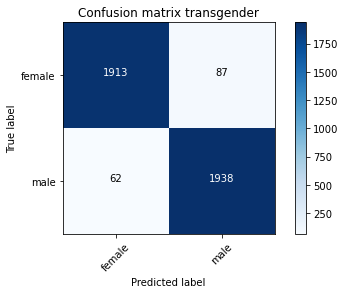

In [245]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix transgender")

### 7.2 Trangender Prediction

In [246]:
y_pred_trans = np.argmax(bestmodel.predict(Test_trans_set), axis=-1)
y_pred_trans

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [247]:
y_true_trans = Test_trans_set.classes
y_true_trans

array([0, 0, 0, ..., 1, 1, 1])

In [248]:
target_names = ['female', 'male']
cr_trans = classification_report(y_true_trans, y_pred_trans, target_names=target_names)
print(cr_trans)

              precision    recall  f1-score   support

      female       0.13      0.09      0.11       660
        male       0.28      0.36      0.32       660

    accuracy                           0.23      1320
   macro avg       0.21      0.23      0.21      1320
weighted avg       0.21      0.23      0.21      1320



confusion matrix, without normalization
[[129 531]
 [589  71]]


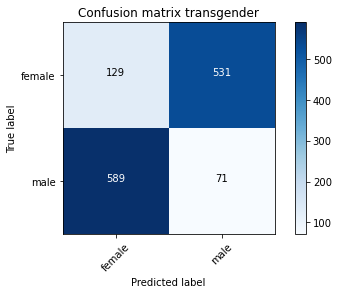

In [249]:
plot_confusion_matrix(cm=cm_trans, classes=target_names, title="Confusion matrix transgender")

# <font color='#E8800A'>8. Transfer learning </font><a class="anchor" id="nineth-bullet"></a>
[Back to TOC](#toc)

Building a neural network for image classification is not always easy when you don’t have a lot of data. In recent years, there have been a few major advances in this space that have made building a valuable model more possible without having millions of images to train on. Most notably, transfer learning tops this list.

## 8.1 Competition-winning deep neural networks

competition-winning deep neural
networks with pretrained weights are used for image-based gender
recognition and age estimation. Transfer learning is explored
using both VGG19 and VGGFace pretrained models

# <font color='#E8800A'>9. Train a Fine-Tuned Neural Network with TensorFlow's Keras API </font><a class="anchor" id="nineth-bullet"></a>
[Back to TOC](#toc)

# 1. VGG16

### a) Bulid the Model

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. 

In [143]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

In [144]:
base_model = tf.keras.applications.vgg16.VGG16()

In [145]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [146]:
type(base_model)

tensorflow.python.keras.engine.functional.Functional

In [147]:
VGG16_model = Sequential()
for layer in base_model.layers[:-1]:
    VGG16_model.add(layer)

In [148]:
for layer in VGG16_model.layers:
    layer.trainable = False

In [149]:
VGG16_model.add(Dense(units=2, activation='softmax'))

In [150]:
VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [151]:
VGG16_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### b) Preprocessing

In [152]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [153]:
training_set = train_datagen.flow_from_directory('dataset/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory('dataset/Validation',
                                            target_size = (224, 224),
                                                 batch_size = 10,
                                                class_mode = 'categorical')
                                            #class_mode = 'binary'
    
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary'
    
Test_trans_set = test_datagen.flow_from_directory('dataset/Test_trans',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary'

Found 43009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.


### c) Train the model

In [154]:
history=VGG16_model.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 5,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/5
1344/1344 [==============================] - 1331s 990ms/step - loss: 0.3823 - accuracy: 0.8551 - val_loss: 0.2045 - val_accuracy: 0.9200
Epoch 2/5
1344/1344 [==============================] - 1341s 998ms/step - loss: 0.3048 - accuracy: 0.8894 - val_loss: 0.3219 - val_accuracy: 0.8900
Epoch 3/5
1344/1344 [==============================] - 1336s 994ms/step - loss: 0.2835 - accuracy: 0.9076 - val_loss: 0.2999 - val_accuracy: 0.8960
Epoch 4/5
1344/1344 [==============================] - 1330s 989ms/step - loss: 0.2914 - accuracy: 0.9009 - val_loss: 0.6263 - val_accuracy: 0.8280
Epoch 5/5
1344/1344 [==============================] - 1346s 1s/step - loss: 0.2760 - accuracy: 0.9094 - val_loss: 0.3493 - val_accuracy: 0.9060


In [ ]:
# # save the model
# VGG16_model.save('VGG16_model.h5')

In [275]:
# # Loading the model
# VGG16_model = load_model('VGG16_model.h5')
# VGG16_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

### d) Displaying curves of loss and accuracy during training 

In [155]:
#history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

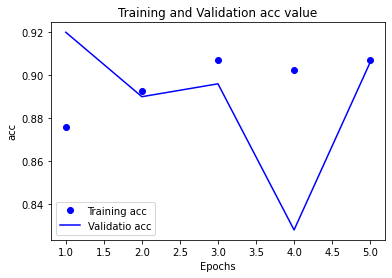

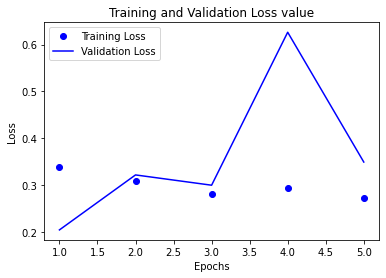

In [156]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validatio acc')
plt.title('Training and Validation acc value')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### e) Male & Famele Prediction

In [157]:
y_pred = np.argmax(VGG16_model.predict(test_set), axis=-1)
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [158]:
y_true = test_set.classes
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [159]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1679,  321],
       [  67, 1933]], dtype=int64)

In [160]:
target_names = ['female', 'male']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

      female       0.96      0.84      0.90      2000
        male       0.86      0.97      0.91      2000

    accuracy                           0.90      4000
   macro avg       0.91      0.90      0.90      4000
weighted avg       0.91      0.90      0.90      4000



confusion matrix, without normalization
[[1679  321]
 [  67 1933]]


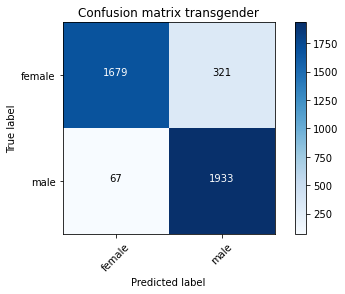

In [161]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix transgender")

### f) Trangender Prediction

In [162]:
y_pred_trans = np.argmax(VGG16_model.predict(Test_trans_set), axis=-1)
y_pred_trans

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [163]:
y_true_trans = Test_trans_set.classes
y_true_trans

array([0, 0, 0, ..., 1, 1, 1])

In [164]:
cm_trans = confusion_matrix(y_true_trans, y_pred_trans)
cm_trans

array([[182, 478],
       [568,  92]], dtype=int64)

In [165]:
target_names = ['female', 'male']
cr_trans = classification_report(y_true_trans, y_pred_trans, target_names=target_names)
print(cr_trans)

              precision    recall  f1-score   support

      female       0.24      0.28      0.26       660
        male       0.16      0.14      0.15       660

    accuracy                           0.21      1320
   macro avg       0.20      0.21      0.20      1320
weighted avg       0.20      0.21      0.20      1320



confusion matrix, without normalization
[[182 478]
 [568  92]]


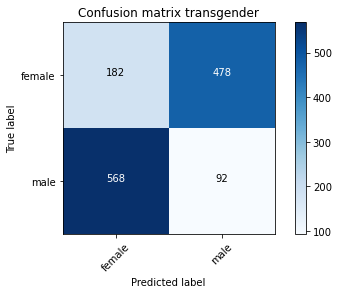

In [166]:
plot_confusion_matrix(cm=cm_trans, classes=target_names, title="Confusion matrix transgender")

# 2. VGG19

### a) Build the Model

In [31]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

In [32]:
base_model = tf.keras.applications.vgg19.VGG19()

In [33]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [34]:
VGG19_model = Sequential()
for layer in base_model.layers[:-1]:
    VGG19_model.add(layer)

In [35]:
for layer in VGG19_model.layers:
    layer.trainable = False

In [36]:
VGG19_model.add(Dense(units=2, activation='softmax'))

In [37]:
VGG19_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### b) Preprocessing 

In [38]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

In [39]:
training_set = train_datagen.flow_from_directory('dataset/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory('dataset/Validation',
                                            target_size = (224, 224),
                                                 batch_size = 10,
                                                class_mode = 'categorical')
                                            #class_mode = 'binary'
    
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary'
    
Test_trans_set = test_datagen.flow_from_directory('dataset/Test_trans',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary'

Found 43009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.


### c) Train the Model

In [40]:
history=VGG19_model.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 5,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/5
1344/1344 [==============================] - 1652s 1s/step - loss: 0.3672 - accuracy: 0.8656 - val_loss: 0.3121 - val_accuracy: 0.8940
Epoch 2/5
1344/1344 [==============================] - 1634s 1s/step - loss: 0.3167 - accuracy: 0.8900 - val_loss: 0.1981 - val_accuracy: 0.9220
Epoch 3/5
1344/1344 [==============================] - 1630s 1s/step - loss: 0.2850 - accuracy: 0.8957 - val_loss: 0.2841 - val_accuracy: 0.9100
Epoch 4/5
1344/1344 [==============================] - 1631s 1s/step - loss: 0.2801 - accuracy: 0.9001 - val_loss: 0.3049 - val_accuracy: 0.8900
Epoch 5/5
1344/1344 [==============================] - 1635s 1s/step - loss: 0.2803 - accuracy: 0.9096 - val_loss: 0.2361 - val_accuracy: 0.9180


In [ ]:
# # save the model
# VGG19_model.save('VGG19_model.h5')

In [297]:
# # Loading the model
# VGG19_model = load_model('VGG19_model.h5')
# VGG19_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

### d) Displaying curves of loss and accuracy during training 

In [41]:
#history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

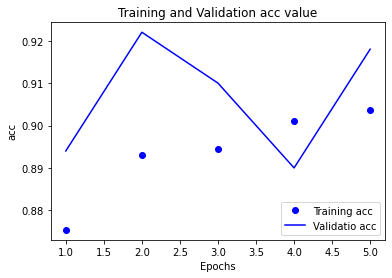

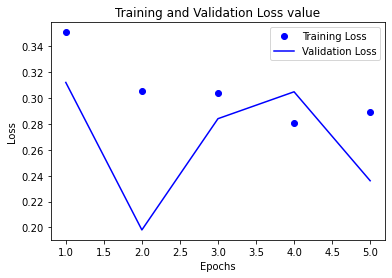

In [42]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validatio acc')
plt.title('Training and Validation acc value')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### e) Male & Famele Prediction

In [43]:
y_pred = np.argmax(VGG19_model.predict(test_set), axis=-1)
y_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [44]:
y_true = test_set.classes
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [45]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1901,   99],
       [ 239, 1761]], dtype=int64)

In [46]:
target_names = ['female', 'male']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

      female       0.89      0.95      0.92      2000
        male       0.95      0.88      0.91      2000

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



confusion matrix, without normalization
[[1901   99]
 [ 239 1761]]


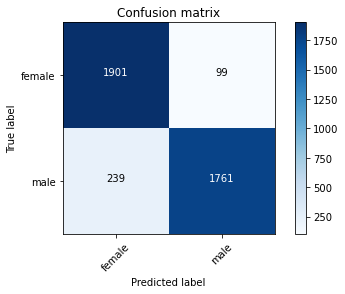

In [47]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix")

### f) Transgender Prediction

In [48]:
y_pred_trans = np.argmax(VGG19_model.predict(Test_trans_set), axis=-1)
y_pred_trans

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [49]:
y_true_trans = Test_trans_set.classes
y_true_trans

array([0, 0, 0, ..., 1, 1, 1])

In [50]:
cm_trans = confusion_matrix(y_true_trans, y_pred_trans)
cm_trans

array([[210, 450],
       [590,  70]], dtype=int64)

In [51]:
target_names = ['female', 'male']
cr_trans = classification_report(y_true_trans, y_pred_trans, target_names=target_names)
print(cr_trans)

              precision    recall  f1-score   support

      female       0.26      0.32      0.29       660
        male       0.13      0.11      0.12       660

    accuracy                           0.21      1320
   macro avg       0.20      0.21      0.20      1320
weighted avg       0.20      0.21      0.20      1320



confusion matrix, without normalization
[[210 450]
 [590  70]]


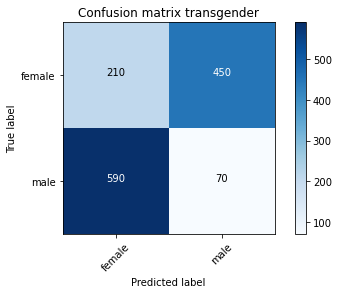

In [52]:
plot_confusion_matrix(cm=cm_trans, classes=target_names, title="Confusion matrix transgender")

# 3. VGGFace

Shortly after the release of the VGG architectures, the Visual Geometry Group published another paper called “Deep
Face Recognition” [24]. In this paper, VGG16 is trained from scratch for facial recognition using a dataset of 2.6 million
face images. Prior studies have shown that transfer learning using neural networks with facial recognition pretraining can
produce highly effective results for gender recognition and age estimation [16]. Since facial recognition neural networks have already been trained to distinguish human features, the features that they extract may be more useful for determining age and gender from a photo than the features extracted by a more general neural network.

[16] G. Antipov, M. Baccouche, S.-A. Berrani, and J.-L. Dugelay, “Effective Training of Convolutional Neural Networks for Face-based Gender and Age Prediction,” Pattern Recognition, vol. 72, p. 15–26, 2017. 1, 2, 3, 5

[24] O. M. Parkhi, A. Vedaldi, and A. Zisserman,“”Deep Face Recognition”,” in British Machine Vision Conference, 2015. 2, 6

The keras-vggface library provides three pre-trained VGGModels, a VGGFace1 model via model=’vgg16′ (the default), and two VGGFace2 models ‘resnet50‘ and ‘senet50‘.

In this project will be used ‘senet50‘ VGGFace2 model, the VGG16 and ResNet50 have been tested on the original version

In [ ]:
# pip install keras-vggface

In [ ]:
# pip install keras_applications

In [59]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

### a) Build the Model

In [60]:
# create the base pre-trained model
base_model = VGGFace(model='senet50', include_top=False)

In [61]:
base_model.summary()

Model: "vggface_senet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, None, None, 6 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, None, None, 6 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_81 (Activation)      (None, None, None, 6 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________

In [62]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a prediction layer layer with 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
VGGFace_model = Model(inputs=base_model.input, outputs=predictions)

In [63]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [64]:
VGGFace_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, None, None, 6 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, None, None, 6 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_81 (Activation)      (None, None, None, 6 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [65]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_4
1 conv1/7x7_s2
2 conv1/7x7_s2/bn
3 activation_81
4 max_pooling2d_1
5 conv2_1_1x1_reduce
6 conv2_1_1x1_reduce/bn
7 activation_82
8 conv2_1_3x3
9 conv2_1_3x3/bn
10 activation_83
11 conv2_1_1x1_increase
12 conv2_1_1x1_increase/bn
13 global_average_pooling2d_16
14 reshape_16
15 conv2_1_1x1_down
16 activation_84
17 conv2_1_1x1_up
18 activation_85
19 conv2_1_1x1_proj
20 multiply_16
21 conv2_1_1x1_proj/bn
22 add_16
23 activation_86
24 conv2_2_1x1_reduce
25 conv2_2_1x1_reduce/bn
26 activation_87
27 conv2_2_3x3
28 conv2_2_3x3/bn
29 activation_88
30 conv2_2_1x1_increase
31 conv2_2_1x1_increase/bn
32 global_average_pooling2d_17
33 reshape_17
34 conv2_2_1x1_down
35 activation_89
36 conv2_2_1x1_up
37 activation_90
38 multiply_17
39 add_17
40 activation_91
41 conv2_3_1x1_reduce
42 conv2_3_1x1_reduce/bn
43 activation_92
44 conv2_3_3x3
45 conv2_3_3x3/bn
46 activation_93
47 conv2_3_1x1_increase
48 conv2_3_1x1_increase/bn
49 global_average_pooling2d_18
50 reshape_18
51 conv2_3_1x1_down
52 acti

In [66]:
VGGFace_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### b) Preprocessing

In [67]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [68]:
training_set = train_datagen.flow_from_directory('dataset/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory('dataset/Validation',
                                            target_size = (224, 224),
                                                 batch_size = 10,
                                                class_mode = 'categorical')
                                            #class_mode = 'binary'
    
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary'
    
Test_trans_set = test_datagen.flow_from_directory('dataset/Test_trans',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary'

Found 43009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.


### c) Train the Model

In [69]:
history=VGGFace_model.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 5,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/5
1344/1344 [==============================] - 619s 456ms/step - loss: 0.7246 - accuracy: 0.9468 - val_loss: 0.1149 - val_accuracy: 0.9700
Epoch 2/5
1344/1344 [==============================] - 598s 445ms/step - loss: 0.1387 - accuracy: 0.9623 - val_loss: 0.1351 - val_accuracy: 0.9660
Epoch 3/5
1344/1344 [==============================] - 595s 443ms/step - loss: 0.1137 - accuracy: 0.9653 - val_loss: 0.0596 - val_accuracy: 0.9840
Epoch 4/5
1344/1344 [==============================] - 604s 449ms/step - loss: 0.1140 - accuracy: 0.9665 - val_loss: 0.1172 - val_accuracy: 0.9660
Epoch 5/5
1344/1344 [==============================] - 595s 443ms/step - loss: 0.1119 - accuracy: 0.9693 - val_loss: 0.0812 - val_accuracy: 0.9700


In [ ]:
# # save the model
# VGGFace_model.save('VGGFace_model.h5')

In [ ]:
# # Loading the model
# VGGFace_model = load_model('VGGFace_model.h5')
# VGGFace_model.summary()

### d) Displaying curves of loss and accuracy during training 

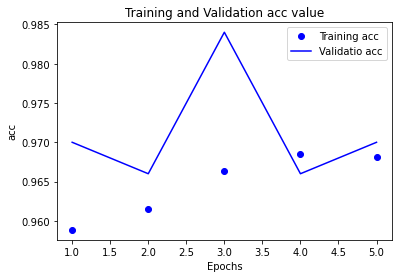

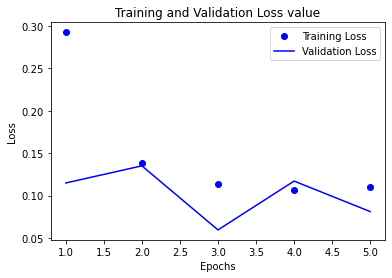

In [70]:
#history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validatio acc')
plt.title('Training and Validation acc value')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### e) Test set Predtiction

In [71]:
y_pred = np.argmax(VGGFace_model.predict(test_set), axis=-1)
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [72]:
y_true = test_set.classes
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [73]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1955,   45],
       [  61, 1939]], dtype=int64)

In [74]:
target_names = ['female', 'male']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

      female       0.97      0.98      0.97      2000
        male       0.98      0.97      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



confusion matrix, without normalization
[[1955   45]
 [  61 1939]]


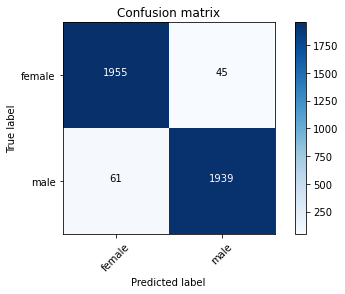

In [75]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix")

### f) Transgender set Prediction

In [76]:
y_pred_trans = np.argmax(VGGFace_model.predict(Test_trans_set), axis=-1)
y_pred_trans

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [77]:
y_true_trans = Test_trans_set.classes
y_true_trans

array([0, 0, 0, ..., 1, 1, 1])

In [78]:
cm_trans = confusion_matrix(y_true_trans, y_pred_trans)
cm_trans

array([[ 44, 616],
       [504, 156]], dtype=int64)

In [79]:
target_names = ['female', 'male']
cr_trans = classification_report(y_true_trans, y_pred_trans, target_names=target_names)
print(cr_trans)

              precision    recall  f1-score   support

      female       0.08      0.07      0.07       660
        male       0.20      0.24      0.22       660

    accuracy                           0.15      1320
   macro avg       0.14      0.15      0.15      1320
weighted avg       0.14      0.15      0.15      1320



confusion matrix, without normalization
[[ 44 616]
 [504 156]]


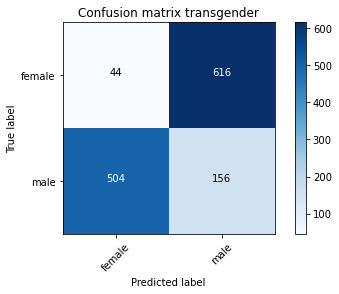

In [80]:
plot_confusion_matrix(cm=cm_trans, classes=target_names, title="Confusion matrix transgender")

# 4. ResNet50

In [82]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

### a) Build the Model

In [83]:
base_model = ResNet50(weights='imagenet', include_top=False)

In [84]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [85]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
ResNet50_model = Model(inputs=base_model.input, outputs=predictions)

In [86]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [87]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_5
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [88]:
ResNet50_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### b) Preprocessing

In [89]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [90]:
training_set = train_datagen.flow_from_directory('dataset/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory('dataset/Validation',
                                            target_size = (224, 224),
                                                 batch_size = 10,
                                                class_mode = 'categorical')
                                            #class_mode = 'binary'
    
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary'
    
Test_trans_set = test_datagen.flow_from_directory('dataset/Test_trans',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary'

Found 43009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.


### c) Train the Model

In [91]:
history=ResNet50_model.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 5,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/5
1344/1344 [==============================] - 734s 544ms/step - loss: 0.3386 - accuracy: 0.8838 - val_loss: 0.1585 - val_accuracy: 0.9380
Epoch 2/5
1344/1344 [==============================] - 752s 560ms/step - loss: 0.1875 - accuracy: 0.9287 - val_loss: 0.1281 - val_accuracy: 0.9480
Epoch 3/5
1344/1344 [==============================] - 747s 556ms/step - loss: 0.1714 - accuracy: 0.9333 - val_loss: 0.1605 - val_accuracy: 0.9460
Epoch 4/5
1344/1344 [==============================] - 739s 550ms/step - loss: 0.1497 - accuracy: 0.9414 - val_loss: 0.1207 - val_accuracy: 0.9560
Epoch 5/5
1344/1344 [==============================] - 736s 547ms/step - loss: 0.1479 - accuracy: 0.9459 - val_loss: 0.1219 - val_accuracy: 0.9580


In [92]:
# # save the model
# ResNet50_model.save('ResNet50_model.h5')

In [ ]:
# # Loading the model
# ResNet50_model = load_model('ResNet50_model.h5')
# ResNet50_model.summary()

### d) Displaying curves of loss and accuracy during training 

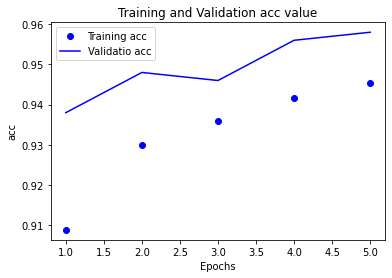

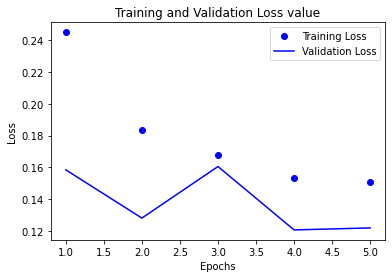

In [93]:
#history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validatio acc')
plt.title('Training and Validation acc value')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### e) Test set Prediction

In [94]:
y_pred = np.argmax(ResNet50_model.predict(test_set), axis=-1)
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [95]:
y_true = test_set.classes
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [96]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1921,   79],
       [ 108, 1892]], dtype=int64)

In [97]:
target_names = ['female', 'male']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

      female       0.95      0.96      0.95      2000
        male       0.96      0.95      0.95      2000

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



confusion matrix, without normalization
[[1921   79]
 [ 108 1892]]


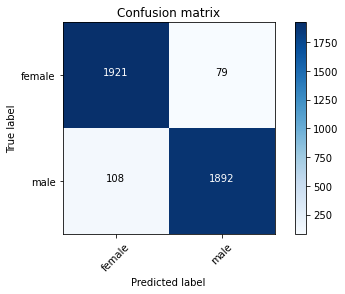

In [98]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix")

### f) Trandender set Prediction

In [99]:
y_pred_trans = np.argmax(ResNet50_model.predict(Test_trans_set), axis=-1)
y_pred_trans

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [100]:
y_true_trans = Test_trans_set.classes
y_true_trans

array([0, 0, 0, ..., 1, 1, 1])

In [101]:
cm_trans = confusion_matrix(y_true_trans, y_pred_trans)
cm_trans

array([[ 93, 567],
       [578,  82]], dtype=int64)

In [102]:
target_names = ['female', 'male']
cr_trans = classification_report(y_true_trans, y_pred_trans, target_names=target_names)
print(cr_trans)

              precision    recall  f1-score   support

      female       0.14      0.14      0.14       660
        male       0.13      0.12      0.13       660

    accuracy                           0.13      1320
   macro avg       0.13      0.13      0.13      1320
weighted avg       0.13      0.13      0.13      1320



confusion matrix, without normalization
[[1921   79]
 [ 108 1892]]


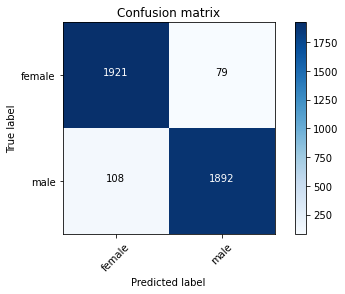

In [103]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix")

confusion matrix, without normalization
[[ 93 567]
 [578  82]]


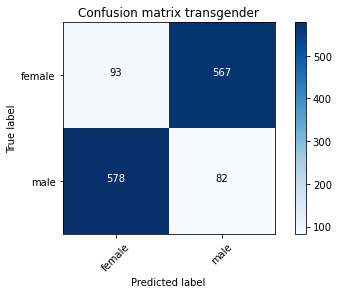

In [104]:
plot_confusion_matrix(cm=cm_trans, classes=target_names, title="Confusion matrix transgender")

# 5. Xception

Xception — With Depthwise Separable Convolution, Better Than Inception-v3 (Image Classification)

 Xception [1] by Google, stands for Extreme version of Inception, is reviewed. With a modified depthwise separable convolution, it is even better than Inception-v3 [2] (also by Google, 1st Runner Up in ILSVRC 2015) for both ImageNet ILSVRC and JFT datasets.

[2017 CVPR] [Xception] Xception: Deep Learning with Depthwise Separable Convolutions <br>
[2016 CVPR] [Inception-v3] Rethinking the Inception Architecture for Computer Vision


In [105]:
from keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [106]:
# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)

In [107]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [108]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
Xception_model = Model(inputs=base_model.input, outputs=predictions)

In [109]:

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [110]:
Xception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [111]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_6
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add_32
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_33
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_34
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_35
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepcon

In [112]:
# compile the model (should be done *after* setting layers to non-trainable)
#Xception_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Xception_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### b) Preprocessing

In [113]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [114]:
training_set = train_datagen.flow_from_directory('dataset/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')

val_set = test_datagen.flow_from_directory('dataset/Validation',
                                            target_size = (224, 224),
                                                 batch_size = 10,
                                                class_mode = 'categorical')
                                            #class_mode = 'binary'
    
test_set = test_datagen.flow_from_directory('dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary'
    
Test_trans_set = test_datagen.flow_from_directory('dataset/Test_trans',
                                            target_size = (224, 224),
                                            batch_size = 10,
                                            class_mode = 'categorical', shuffle=False)
                                            #class_mode = 'binary

Found 43009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.


### c) Train the model

In [115]:
history=Xception_model.fit(training_set,
                         steps_per_epoch = 1344, # if batch_size=1 -> steps_per_epoch=8000
                         epochs = 5,
                         validation_data = val_set,
                         validation_steps = 50)

Epoch 1/5
1344/1344 [==============================] - 625s 463ms/step - loss: 0.2818 - accuracy: 0.8893 - val_loss: 0.2127 - val_accuracy: 0.9200
Epoch 2/5
1344/1344 [==============================] - 621s 462ms/step - loss: 0.1988 - accuracy: 0.9234 - val_loss: 0.1557 - val_accuracy: 0.9400
Epoch 3/5
1344/1344 [==============================] - 614s 457ms/step - loss: 0.1809 - accuracy: 0.9323 - val_loss: 0.1625 - val_accuracy: 0.9300
Epoch 4/5
1344/1344 [==============================] - 614s 457ms/step - loss: 0.1856 - accuracy: 0.9324 - val_loss: 0.1900 - val_accuracy: 0.9240
Epoch 5/5
1344/1344 [==============================] - 613s 456ms/step - loss: 0.1792 - accuracy: 0.9280 - val_loss: 0.1685 - val_accuracy: 0.9300


In [ ]:
# # save the model
# Xception_model.save('Xception_model2.h5')

In [360]:
# # Loading the model
# Xception_model = load_model('Xception_model2.h5')
# Xception_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

### d) Displaying curves of loss and accuracy during training 

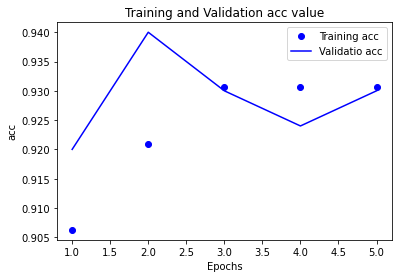

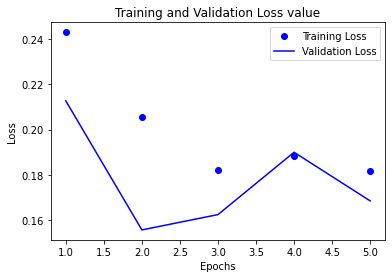

In [116]:
#history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validatio acc')
plt.title('Training and Validation acc value')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss value')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### e) Test set Prediction

In [117]:
y_pred = np.argmax(Xception_model.predict(test_set), axis=-1)
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [118]:
y_true = test_set.classes
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [119]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1905,   95],
       [ 150, 1850]], dtype=int64)

In [120]:
target_names = ['female', 'male']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

      female       0.93      0.95      0.94      2000
        male       0.95      0.93      0.94      2000

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



confusion matrix, without normalization
[[1905   95]
 [ 150 1850]]


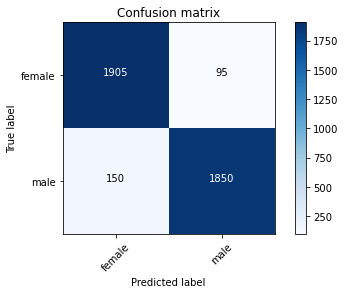

In [121]:
plot_confusion_matrix(cm=cm, classes=target_names, title="Confusion matrix")

### f) Trangender Prediction

In [122]:
y_pred_trans = np.argmax(Xception_model.predict(Test_trans_set), axis=-1)
y_pred_trans

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [123]:
y_true_trans = Test_trans_set.classes
y_true_trans

array([0, 0, 0, ..., 1, 1, 1])

In [124]:
cm_trans = confusion_matrix(y_true_trans, y_pred_trans)
cm_trans

array([[160, 500],
       [613,  47]], dtype=int64)

In [125]:
cm_trans = confusion_matrix(y_true_trans, y_pred_trans)
cm_trans

array([[160, 500],
       [613,  47]], dtype=int64)

In [126]:
target_names = ['female', 'male']
cr_trans = classification_report(y_true_trans, y_pred_trans, target_names=target_names)
print(cr_trans)

              precision    recall  f1-score   support

      female       0.21      0.24      0.22       660
        male       0.09      0.07      0.08       660

    accuracy                           0.16      1320
   macro avg       0.15      0.16      0.15      1320
weighted avg       0.15      0.16      0.15      1320



confusion matrix, without normalization
[[160 500]
 [613  47]]


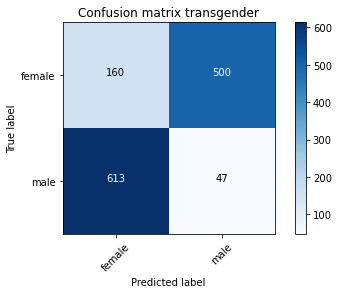

In [127]:
plot_confusion_matrix(cm=cm_trans, classes=target_names, title="Confusion matrix transgender")

# <font color='#E8800A'>10. Extensions </font><a class="anchor" id="tenth-bullet"></a>
[Back to TOC](#toc)

Create a Function. Update the example and add a function that given an image filename and the loaded model will return the classification result.